## Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, image_dim=28, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()

        # Run dummy input through conv layers to compute input_len correctly
        with torch.no_grad():
            dummy = torch.zeros(1, 1, image_dim, image_dim)
            x = self.relu(self.conv1(dummy))
            x = self.pool(self.relu(self.conv2(x)))
            self.input_len = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(in_features=self.input_len, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=128)
        self.out = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.out(x)
        return x

In [ ]:
import torch.serialization
torch.serialization.add_safe_globals(["Subset"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/CV_Final Project/VAE_vs_Others/AZIZ/Balanced/all_images/1000/VQVAE_all_images_balanced_1000.pt"
#subset = torch.load(data_path, map_location=torch.device('cpu'), weights_only=False)

subset = torch.load(data_path, weights_only=False)

In [ ]:
print(subset.keys())

dict_keys(['images', 'labels', 'model', 'dataset_type', 'size'])


In [ ]:
#images = torch.stack([subset[i][0] for i in range(len(subset))])
images = subset['images']
labels = torch.tensor(subset['labels'])
images = (images - 0.5) / 0.5

#labels = torch.tensor([subset[i][1] for i in range(len(subset))])
dataset = torch.utils.data.TensorDataset(images, labels)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

<ipython-input-107-39e7e261d340>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(subset['labels'])


In [ ]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss()

def train_model(model, train_loader, optimizer, loss_fn, device, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f}")

train_model(model, train_loader, optimizer, loss_fn, device, num_epochs=50)

Epoch 1/50 - Loss: 124.5704
Epoch 2/50 - Loss: 92.6188
Epoch 3/50 - Loss: 86.6307
Epoch 4/50 - Loss: 82.5678
Epoch 5/50 - Loss: 79.4376
Epoch 6/50 - Loss: 78.1498
Epoch 7/50 - Loss: 75.7723
Epoch 8/50 - Loss: 74.7502
Epoch 9/50 - Loss: 73.9810
Epoch 10/50 - Loss: 72.2778
Epoch 11/50 - Loss: 70.6787
Epoch 12/50 - Loss: 69.5145
Epoch 13/50 - Loss: 69.8042
Epoch 14/50 - Loss: 67.8087
Epoch 15/50 - Loss: 68.4493
Epoch 16/50 - Loss: 67.9004
Epoch 17/50 - Loss: 66.4073
Epoch 18/50 - Loss: 65.6012
Epoch 19/50 - Loss: 65.2753
Epoch 20/50 - Loss: 65.1742
Epoch 21/50 - Loss: 65.5005
Epoch 22/50 - Loss: 64.2256
Epoch 23/50 - Loss: 63.4975
Epoch 24/50 - Loss: 63.3091
Epoch 25/50 - Loss: 62.7425
Epoch 26/50 - Loss: 62.9452
Epoch 27/50 - Loss: 62.5976
Epoch 28/50 - Loss: 62.4936
Epoch 29/50 - Loss: 63.1762
Epoch 30/50 - Loss: 62.4180
Epoch 31/50 - Loss: 62.5040
Epoch 32/50 - Loss: 62.0879
Epoch 33/50 - Loss: 62.1405
Epoch 34/50 - Loss: 62.0197
Epoch 35/50 - Loss: 62.0004
Epoch 36/50 - Loss: 62.1482


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load test dataset
test_dataset = datasets.FashionMNIST(
    root=".data", train=False, download=True, transform=transforms.ToTensor()
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"✔️ Loaded FashionMNIST test set with {len(test_dataset)} images.")

✔️ Loaded FashionMNIST test set with 10000 images.


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(y.numpy())

    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)

    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4)

    print(f"\n🧪 Test Accuracy: {acc:.4f}")
    print(report)

# Run it:
evaluate_model(model, test_loader, device)


🧪 Test Accuracy: 0.5287
              precision    recall  f1-score   support

           0     0.7332    0.7530    0.7430      1000
           1     0.9965    0.8440    0.9139      1000
           2     0.7750    0.5340    0.6323      1000
           3     0.9953    0.2100    0.3468      1000
           4     0.4666    0.8740    0.6084      1000
           5     1.0000    0.0420    0.0806      1000
           6     0.5000    0.1070    0.1763      1000
           7     1.0000    0.0070    0.0139      1000
           8     0.2543    0.9960    0.4052      1000
           9     0.7836    0.9200    0.8464      1000

    accuracy                         0.5287     10000
   macro avg     0.7505    0.5287    0.4767     10000
weighted avg     0.7505    0.5287    0.4767     10000



In [ ]:
def extract_embeddings(model, data_loader):
    embeddings = []
    labels = []

    # hook: input to final Linear
    linear_layers = [m for m in model.modules() if isinstance(m, nn.Linear)]
    final_fc = linear_layers[-1]

    def hook_fn(module, input):
        embeddings.append(input[0].detach().cpu().numpy())

    hook_handle = final_fc.register_forward_pre_hook(hook_fn)

    model.eval()
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            _ = model(x)
            labels.append(y.cpu().numpy())

    hook_handle.remove()

    return np.vstack(embeddings), np.concatenate(labels)

embeddings, labels = extract_embeddings(model, train_loader)
print(f"✔️ Extracted embeddings: {embeddings.shape}, labels: {labels.shape}")


✔️ Extracted embeddings: (2104, 128), labels: (2104,)


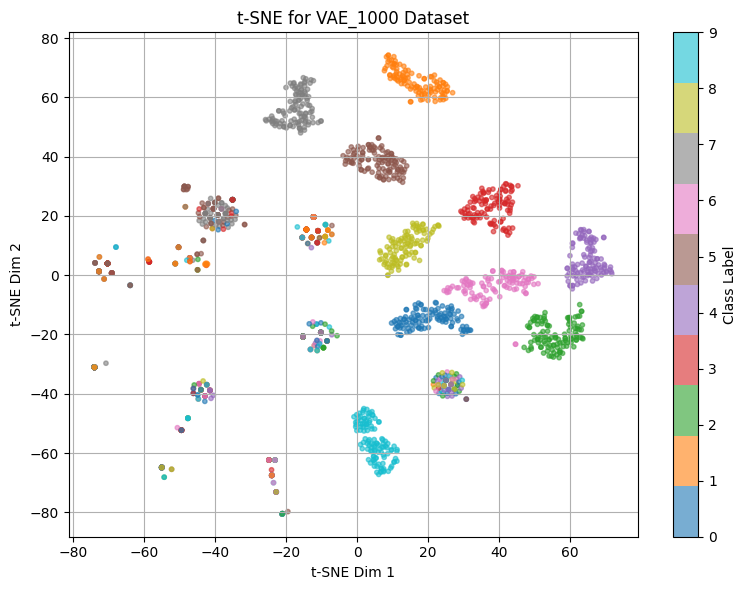

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(embeddings, labels, title="t-SNE of CNN Embeddings", perplexity=30, figsize=(8, 6)):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    reduced = tsne.fit_transform(embeddings)

    plt.figure(figsize=figsize)
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', alpha=0.6, s=10)
    plt.colorbar(scatter, ticks=range(10), label='Class Label')
    plt.title(title)
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run it:
plot_tsne(embeddings, labels, title=f"t-SNE for VAE_1000 Dataset")


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, test_size=0.3, random_state=42, stratify=labels
)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=4)

print(f"\n📊 CART accuracy: {acc:.4f}")
print(report)


📊 CART accuracy: 0.6155
              precision    recall  f1-score   support

           0     0.9630    0.4127    0.5778        63
           1     0.5556    0.7937    0.6536        63
           2     0.4143    0.9062    0.5686        64
           3     0.8140    0.5556    0.6604        63
           4     0.7273    0.5079    0.5981        63
           5     0.9474    0.5625    0.7059        64
           6     0.5000    0.4677    0.4833        62
           7     0.5729    0.8594    0.6875        64
           8     0.9375    0.4839    0.6383        62
           9     0.5938    0.5938    0.5938        64

    accuracy                         0.6155       632
   macro avg     0.7026    0.6143    0.6167       632
weighted avg     0.7021    0.6155    0.6170       632



In [ ]:
import os
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Your CNN model
class CNN(nn.Module):
    def __init__(self, image_dim=28, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()

        # Run dummy input through conv layers to compute input_len correctly
        with torch.no_grad():
            dummy = torch.zeros(1, 1, image_dim, image_dim)
            x = self.relu(self.conv1(dummy))
            x = self.pool(self.relu(self.conv2(x)))
            self.input_len = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(in_features=self.input_len, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=128)
        self.out = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.out(x)
        return x

# Configuration
imbalance_types = ["Balanced", "Highly Imbalanced", "Semi Imbalanced"]
sample_sizes = ["1000", "2000", "3000", "4000", "5000"]
model_names = [
    "Diffusion", "CLIP-guided Diffusion", "BIGGAN", "GAN", "VQVAE", "VAE",
    "DVAE (gaussian)", "DVAE (salt_pepper)", "DVAE (rotation)", "DVAE (brightness)", "DVAE (contrast)", "DVAE (blur)"
]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Standard test loader
test_dataset = datasets.FashionMNIST(root=".data", train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Helper Functions
def train_model(model, train_loader, optimizer, loss_fn, device, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = loss_fn(model(x), y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f}")

def evaluate_model(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            outputs = model(x)
            preds.append(outputs.argmax(dim=1).cpu().numpy())
            labels.append(y.numpy())
    y_true, y_pred = np.concatenate(labels), np.concatenate(preds)
    return accuracy_score(y_true, y_pred), classification_report(y_true, y_pred, digits=4)

def extract_embeddings(model, loader):
    embeddings, labels = [], []
    final_fc = [m for m in model.modules() if isinstance(m, nn.Linear)][-1]
    def hook_fn(m, i): embeddings.append(i[0].detach().cpu().numpy())
    hook = final_fc.register_forward_pre_hook(hook_fn)
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            _ = model(x)
            labels.append(y.cpu().numpy())
    hook.remove()
    return np.vstack(embeddings), np.concatenate(labels)

def plot_tsne(embeddings, labels, path):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', alpha=0.6, s=10)
    plt.colorbar(scatter, ticks=range(10), label='Class')
    plt.title("t-SNE of CNN Embeddings")
    plt.grid(True)
    plt.savefig(path)
    plt.close()

# MAIN LOOP
base_path = "/content/drive/My Drive/AZIZ"
output_root = "/content/results"

for imbalance in ["Balanced"]:
    for size in sample_sizes:
        for model_name in model_names:
            # Normalize and prepare path components
            suffix = model_name.replace(" ", "_").replace("(", "").replace(")", "")
            imbalance_folder = imbalance.replace(" ", "_")  # For saving
            subfolder = "balanced" if imbalance == "Balanced" else "high" if "Highly" in imbalance else "semi"
            file_name = f"{model_name}_all_images_{subfolder}_{size}.pt"
            file_path = os.path.join(base_path, imbalance, "all_images", size, file_name)

            if not os.path.exists(file_path):
                print(f"⚠️ Skipping missing file: {file_path}")
                continue

            print(f"\n📂 Processing: {file_path}")

            # Load data
            data = torch.load(file_path, map_location='cpu')
            images = (data['images'] - 0.5) / 0.5
            labels = torch.tensor(data['labels'])
            dataset = TensorDataset(images, labels)
            train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

            # Train CNN
            model = CNN().to(device)
            optimizer = optim.Adam(model.parameters(), lr=3e-4)
            loss_fn = nn.CrossEntropyLoss()
            train_model(model, train_loader, optimizer, loss_fn, device, num_epochs=50)

            # Evaluate CNN
            test_acc, test_report = evaluate_model(model, test_loader)

            # Create model-specific output directory
            model_output_dir = os.path.join(output_root, imbalance_folder, size, suffix)
            os.makedirs(model_output_dir, exist_ok=True)

            # Save CNN results
            cnn_txt_path = os.path.join(model_output_dir, "cnn.txt")
            with open(cnn_txt_path, "w") as f:
                f.write(f"CNN Test Accuracy: {test_acc:.4f}\n\n{test_report}")
            print(f"✅ Saved CNN results to: {cnn_txt_path}")

            # Extract embeddings + t-SNE
            embeddings, embed_labels = extract_embeddings(model, train_loader)
            tsne_path = os.path.join(model_output_dir, "tsne.png")
            plot_tsne(embeddings, embed_labels, tsne_path)
            print(f"🖼️ Saved t-SNE plot to: {tsne_path}")

            # Train CART on embeddings
            X_train, X_test, y_train, y_test = train_test_split(
                embeddings, embed_labels, test_size=0.3, random_state=42, stratify=embed_labels
            )
            clf = DecisionTreeClassifier(random_state=42)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            cart_acc = accuracy_score(y_test, y_pred)
            cart_report = classification_report(y_test, y_pred, digits=4)

            # Save CART results
            cart_txt_path = os.path.join(model_output_dir, "cart.txt")
            with open(cart_txt_path, "w") as f:
                f.write(f"CART Accuracy: {cart_acc:.4f}\n\n{cart_report}")
            print(f"📊 Saved CART results to: {cart_txt_path}")

100%|██████████| 5.15k/5.15k [00:00<00:00, 5.87MB/s]



📂 Processing: /content/drive/My Drive/AZIZ/Balanced/all_images/1000/Diffusion_all_images_balanced_1000.pt


<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 110.3715
Epoch 2/50 - Loss: 68.7534
Epoch 3/50 - Loss: 55.6609
Epoch 4/50 - Loss: 47.0432
Epoch 5/50 - Loss: 40.3947
Epoch 6/50 - Loss: 35.2458
Epoch 7/50 - Loss: 30.2263
Epoch 8/50 - Loss: 27.0110
Epoch 9/50 - Loss: 24.5385
Epoch 10/50 - Loss: 21.4521
Epoch 11/50 - Loss: 19.2568
Epoch 12/50 - Loss: 17.1718
Epoch 13/50 - Loss: 17.8029
Epoch 14/50 - Loss: 15.7227
Epoch 15/50 - Loss: 12.2560
Epoch 16/50 - Loss: 10.4847
Epoch 17/50 - Loss: 9.3972
Epoch 18/50 - Loss: 7.6188
Epoch 19/50 - Loss: 7.0787
Epoch 20/50 - Loss: 5.4182
Epoch 21/50 - Loss: 4.9107
Epoch 22/50 - Loss: 4.6177
Epoch 23/50 - Loss: 4.0373
Epoch 24/50 - Loss: 3.0426
Epoch 25/50 - Loss: 3.1552
Epoch 26/50 - Loss: 2.8427
Epoch 27/50 - Loss: 2.8856
Epoch 28/50 - Loss: 1.7153
Epoch 29/50 - Loss: 1.5261
Epoch 30/50 - Loss: 2.9632
Epoch 31/50 - Loss: 4.8993
Epoch 32/50 - Loss: 3.4496
Epoch 33/50 - Loss: 2.4117
Epoch 34/50 - Loss: 0.9460
Epoch 35/50 - Loss: 0.4563
Epoch 36/50 - Loss: 0.3291
Epoch 37/50 - Loss: 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Saved CNN results to: /content/results/Balanced/1000/Diffusion/cnn.txt
🖼️ Saved t-SNE plot to: /content/results/Balanced/1000/Diffusion/tsne.png
📊 Saved CART results to: /content/results/Balanced/1000/Diffusion/cart.txt

📂 Processing: /content/drive/My Drive/AZIZ/Balanced/all_images/1000/CLIP-guided Diffusion_all_images_balanced_1000.pt


<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 138.5838
Epoch 2/50 - Loss: 109.3973
Epoch 3/50 - Loss: 99.5797
Epoch 4/50 - Loss: 92.7338
Epoch 5/50 - Loss: 87.8813
Epoch 6/50 - Loss: 82.5939
Epoch 7/50 - Loss: 77.7748
Epoch 8/50 - Loss: 73.3266
Epoch 9/50 - Loss: 68.4504
Epoch 10/50 - Loss: 61.8236
Epoch 11/50 - Loss: 55.6448
Epoch 12/50 - Loss: 46.3253
Epoch 13/50 - Loss: 37.7804
Epoch 14/50 - Loss: 28.1334
Epoch 15/50 - Loss: 25.0692
Epoch 16/50 - Loss: 17.6061
Epoch 17/50 - Loss: 11.3931
Epoch 18/50 - Loss: 7.4800
Epoch 19/50 - Loss: 5.8303
Epoch 20/50 - Loss: 3.0967
Epoch 21/50 - Loss: 2.9408
Epoch 22/50 - Loss: 3.1630
Epoch 23/50 - Loss: 3.1561
Epoch 24/50 - Loss: 2.6752
Epoch 25/50 - Loss: 1.1238
Epoch 26/50 - Loss: 1.5317
Epoch 27/50 - Loss: 2.1800
Epoch 28/50 - Loss: 1.7198
Epoch 29/50 - Loss: 0.4729
Epoch 30/50 - Loss: 0.1828
Epoch 31/50 - Loss: 0.1352
Epoch 32/50 - Loss: 0.1135
Epoch 33/50 - Loss: 0.0954
Epoch 34/50 - Loss: 0.0876
Epoch 35/50 - Loss: 0.0756
Epoch 36/50 - Loss: 0.0688
Epoch 37/50 - Loss

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Saved CNN results to: /content/results/Balanced/1000/CLIP-guided_Diffusion/cnn.txt
🖼️ Saved t-SNE plot to: /content/results/Balanced/1000/CLIP-guided_Diffusion/tsne.png
📊 Saved CART results to: /content/results/Balanced/1000/CLIP-guided_Diffusion/cart.txt

📂 Processing: /content/drive/My Drive/AZIZ/Balanced/all_images/1000/BIGGAN_all_images_balanced_1000.pt


<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 143.4904
Epoch 2/50 - Loss: 111.5922
Epoch 3/50 - Loss: 98.4534
Epoch 4/50 - Loss: 90.8679
Epoch 5/50 - Loss: 81.6133
Epoch 6/50 - Loss: 72.9488
Epoch 7/50 - Loss: 58.3905
Epoch 8/50 - Loss: 45.5080
Epoch 9/50 - Loss: 31.7274
Epoch 10/50 - Loss: 19.8726
Epoch 11/50 - Loss: 14.6520
Epoch 12/50 - Loss: 11.1826
Epoch 13/50 - Loss: 9.0391
Epoch 14/50 - Loss: 8.0093
Epoch 15/50 - Loss: 6.5040
Epoch 16/50 - Loss: 5.7564
Epoch 17/50 - Loss: 4.9896
Epoch 18/50 - Loss: 4.8909
Epoch 19/50 - Loss: 3.0342
Epoch 20/50 - Loss: 5.8732
Epoch 21/50 - Loss: 3.4986
Epoch 22/50 - Loss: 2.4423
Epoch 23/50 - Loss: 1.8856
Epoch 24/50 - Loss: 1.3255
Epoch 25/50 - Loss: 1.2750
Epoch 26/50 - Loss: 0.6398
Epoch 27/50 - Loss: 0.5280
Epoch 28/50 - Loss: 0.4910
Epoch 29/50 - Loss: 0.2885
Epoch 30/50 - Loss: 0.5483
Epoch 31/50 - Loss: 8.7391
Epoch 32/50 - Loss: 1.3551
Epoch 33/50 - Loss: 1.0705
Epoch 34/50 - Loss: 0.4843
Epoch 35/50 - Loss: 0.2201
Epoch 36/50 - Loss: 0.1863
Epoch 37/50 - Loss: 0.1

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 113.5970
Epoch 2/50 - Loss: 60.9160
Epoch 3/50 - Loss: 46.4141
Epoch 4/50 - Loss: 38.6819
Epoch 5/50 - Loss: 32.9725
Epoch 6/50 - Loss: 26.8208
Epoch 7/50 - Loss: 21.7943
Epoch 8/50 - Loss: 22.2335
Epoch 9/50 - Loss: 16.9551
Epoch 10/50 - Loss: 14.9145
Epoch 11/50 - Loss: 13.0385
Epoch 12/50 - Loss: 12.0929
Epoch 13/50 - Loss: 10.7709
Epoch 14/50 - Loss: 9.3412
Epoch 15/50 - Loss: 8.0292
Epoch 16/50 - Loss: 9.0099
Epoch 17/50 - Loss: 7.4659
Epoch 18/50 - Loss: 5.4928
Epoch 19/50 - Loss: 7.3181
Epoch 20/50 - Loss: 4.4761
Epoch 21/50 - Loss: 4.4892
Epoch 22/50 - Loss: 4.0866
Epoch 23/50 - Loss: 3.1506
Epoch 24/50 - Loss: 6.3605
Epoch 25/50 - Loss: 2.7662
Epoch 26/50 - Loss: 3.0090
Epoch 27/50 - Loss: 4.0430
Epoch 28/50 - Loss: 2.3131
Epoch 29/50 - Loss: 1.7619
Epoch 30/50 - Loss: 1.5772
Epoch 31/50 - Loss: 1.3486
Epoch 32/50 - Loss: 2.7073
Epoch 33/50 - Loss: 1.7118
Epoch 34/50 - Loss: 1.3238
Epoch 35/50 - Loss: 1.8920
Epoch 36/50 - Loss: 2.1418
Epoch 37/50 - Loss: 2.2

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 128.0285
Epoch 2/50 - Loss: 93.2257
Epoch 3/50 - Loss: 87.7976
Epoch 4/50 - Loss: 83.2197
Epoch 5/50 - Loss: 80.5919
Epoch 6/50 - Loss: 78.9251
Epoch 7/50 - Loss: 76.4499
Epoch 8/50 - Loss: 75.0537
Epoch 9/50 - Loss: 74.6859
Epoch 10/50 - Loss: 72.7191
Epoch 11/50 - Loss: 72.0717
Epoch 12/50 - Loss: 70.5610
Epoch 13/50 - Loss: 70.2743
Epoch 14/50 - Loss: 69.9681
Epoch 15/50 - Loss: 68.1123
Epoch 16/50 - Loss: 68.0561
Epoch 17/50 - Loss: 67.3550
Epoch 18/50 - Loss: 66.7876
Epoch 19/50 - Loss: 65.9174
Epoch 20/50 - Loss: 66.3553
Epoch 21/50 - Loss: 65.5039
Epoch 22/50 - Loss: 65.0660
Epoch 23/50 - Loss: 64.3478
Epoch 24/50 - Loss: 63.6705
Epoch 25/50 - Loss: 63.2029
Epoch 26/50 - Loss: 63.8032
Epoch 27/50 - Loss: 62.8295
Epoch 28/50 - Loss: 62.6018
Epoch 29/50 - Loss: 62.9984
Epoch 30/50 - Loss: 62.5310
Epoch 31/50 - Loss: 62.3834
Epoch 32/50 - Loss: 63.3843
Epoch 33/50 - Loss: 62.9320
Epoch 34/50 - Loss: 62.1095
Epoch 35/50 - Loss: 62.0338
Epoch 36/50 - Loss: 62.0139


<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 103.8248
Epoch 2/50 - Loss: 63.9178
Epoch 3/50 - Loss: 57.5814
Epoch 4/50 - Loss: 53.5909
Epoch 5/50 - Loss: 51.7995
Epoch 6/50 - Loss: 49.6501
Epoch 7/50 - Loss: 48.3601
Epoch 8/50 - Loss: 47.7544
Epoch 9/50 - Loss: 45.8136
Epoch 10/50 - Loss: 44.3856
Epoch 11/50 - Loss: 42.8493
Epoch 12/50 - Loss: 42.0273
Epoch 13/50 - Loss: 41.9348
Epoch 14/50 - Loss: 40.7040
Epoch 15/50 - Loss: 39.4159
Epoch 16/50 - Loss: 38.2292
Epoch 17/50 - Loss: 38.6247
Epoch 18/50 - Loss: 36.7478
Epoch 19/50 - Loss: 36.0898
Epoch 20/50 - Loss: 35.9889
Epoch 21/50 - Loss: 35.4625
Epoch 22/50 - Loss: 35.1745
Epoch 23/50 - Loss: 34.2582
Epoch 24/50 - Loss: 33.4815
Epoch 25/50 - Loss: 33.3650
Epoch 26/50 - Loss: 33.0555
Epoch 27/50 - Loss: 31.3575
Epoch 28/50 - Loss: 32.5117
Epoch 29/50 - Loss: 31.3553
Epoch 30/50 - Loss: 31.8316
Epoch 31/50 - Loss: 30.4731
Epoch 32/50 - Loss: 30.6752
Epoch 33/50 - Loss: 30.2050
Epoch 34/50 - Loss: 30.1133
Epoch 35/50 - Loss: 29.6873
Epoch 36/50 - Loss: 28.7896


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Saved CNN results to: /content/results/Balanced/1000/VAE/cnn.txt
🖼️ Saved t-SNE plot to: /content/results/Balanced/1000/VAE/tsne.png
📊 Saved CART results to: /content/results/Balanced/1000/VAE/cart.txt

📂 Processing: /content/drive/My Drive/AZIZ/Balanced/all_images/1000/DVAE (gaussian)_all_images_balanced_1000.pt


<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 104.5113
Epoch 2/50 - Loss: 70.2057
Epoch 3/50 - Loss: 62.7427
Epoch 4/50 - Loss: 58.5598
Epoch 5/50 - Loss: 58.4610
Epoch 6/50 - Loss: 53.8760
Epoch 7/50 - Loss: 51.9781
Epoch 8/50 - Loss: 51.3414
Epoch 9/50 - Loss: 49.3080
Epoch 10/50 - Loss: 47.8963
Epoch 11/50 - Loss: 46.1827
Epoch 12/50 - Loss: 45.8826
Epoch 13/50 - Loss: 45.2396
Epoch 14/50 - Loss: 43.7977
Epoch 15/50 - Loss: 43.0065
Epoch 16/50 - Loss: 40.8479
Epoch 17/50 - Loss: 40.6219
Epoch 18/50 - Loss: 40.3370
Epoch 19/50 - Loss: 38.8955
Epoch 20/50 - Loss: 39.0536
Epoch 21/50 - Loss: 37.7580
Epoch 22/50 - Loss: 37.9992
Epoch 23/50 - Loss: 36.4622
Epoch 24/50 - Loss: 36.4566
Epoch 25/50 - Loss: 35.2153
Epoch 26/50 - Loss: 35.3791
Epoch 27/50 - Loss: 35.0431
Epoch 28/50 - Loss: 34.4603
Epoch 29/50 - Loss: 34.1162
Epoch 30/50 - Loss: 33.1701
Epoch 31/50 - Loss: 33.3992
Epoch 32/50 - Loss: 33.1965
Epoch 33/50 - Loss: 32.7799
Epoch 34/50 - Loss: 32.8482
Epoch 35/50 - Loss: 31.9646
Epoch 36/50 - Loss: 32.2013


<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 104.6016
Epoch 2/50 - Loss: 68.8705
Epoch 3/50 - Loss: 62.3295
Epoch 4/50 - Loss: 59.8216
Epoch 5/50 - Loss: 57.0334
Epoch 6/50 - Loss: 54.6136
Epoch 7/50 - Loss: 52.8264
Epoch 8/50 - Loss: 50.7926
Epoch 9/50 - Loss: 49.7073
Epoch 10/50 - Loss: 48.6208
Epoch 11/50 - Loss: 47.5437
Epoch 12/50 - Loss: 46.7391
Epoch 13/50 - Loss: 45.0812
Epoch 14/50 - Loss: 43.4409
Epoch 15/50 - Loss: 43.7807
Epoch 16/50 - Loss: 42.5473
Epoch 17/50 - Loss: 42.8129
Epoch 18/50 - Loss: 40.7297
Epoch 19/50 - Loss: 40.8908
Epoch 20/50 - Loss: 39.5251
Epoch 21/50 - Loss: 39.2919
Epoch 22/50 - Loss: 38.2067
Epoch 23/50 - Loss: 38.0322
Epoch 24/50 - Loss: 37.5539
Epoch 25/50 - Loss: 37.7319
Epoch 26/50 - Loss: 36.5080
Epoch 27/50 - Loss: 36.4105
Epoch 28/50 - Loss: 35.8583
Epoch 29/50 - Loss: 35.1127
Epoch 30/50 - Loss: 34.8026
Epoch 31/50 - Loss: 33.9759
Epoch 32/50 - Loss: 33.6841
Epoch 33/50 - Loss: 34.6708
Epoch 34/50 - Loss: 33.9513
Epoch 35/50 - Loss: 34.1873
Epoch 36/50 - Loss: 33.3447


<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 104.0941
Epoch 2/50 - Loss: 66.9315
Epoch 3/50 - Loss: 61.9412
Epoch 4/50 - Loss: 59.1232
Epoch 5/50 - Loss: 54.7352
Epoch 6/50 - Loss: 52.8785
Epoch 7/50 - Loss: 51.7287
Epoch 8/50 - Loss: 49.6920
Epoch 9/50 - Loss: 48.1347
Epoch 10/50 - Loss: 46.6590
Epoch 11/50 - Loss: 45.1338
Epoch 12/50 - Loss: 43.6104
Epoch 13/50 - Loss: 43.8449
Epoch 14/50 - Loss: 41.6383
Epoch 15/50 - Loss: 41.1242
Epoch 16/50 - Loss: 40.6271
Epoch 17/50 - Loss: 40.1771
Epoch 18/50 - Loss: 38.8001
Epoch 19/50 - Loss: 38.7500
Epoch 20/50 - Loss: 37.6560
Epoch 21/50 - Loss: 37.7040
Epoch 22/50 - Loss: 36.8780
Epoch 23/50 - Loss: 36.2856
Epoch 24/50 - Loss: 36.0370
Epoch 25/50 - Loss: 35.1372
Epoch 26/50 - Loss: 35.2028
Epoch 27/50 - Loss: 34.0582
Epoch 28/50 - Loss: 34.4372
Epoch 29/50 - Loss: 33.3916
Epoch 30/50 - Loss: 34.4642
Epoch 31/50 - Loss: 33.5949
Epoch 32/50 - Loss: 32.4500
Epoch 33/50 - Loss: 32.1269
Epoch 34/50 - Loss: 32.8207
Epoch 35/50 - Loss: 31.4832
Epoch 36/50 - Loss: 31.6547


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Saved CNN results to: /content/results/Balanced/1000/DVAE_rotation/cnn.txt
🖼️ Saved t-SNE plot to: /content/results/Balanced/1000/DVAE_rotation/tsne.png
📊 Saved CART results to: /content/results/Balanced/1000/DVAE_rotation/cart.txt

📂 Processing: /content/drive/My Drive/AZIZ/Balanced/all_images/1000/DVAE (brightness)_all_images_balanced_1000.pt


<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 104.7680
Epoch 2/50 - Loss: 67.8998
Epoch 3/50 - Loss: 62.4641
Epoch 4/50 - Loss: 57.0277
Epoch 5/50 - Loss: 56.0223
Epoch 6/50 - Loss: 53.5688
Epoch 7/50 - Loss: 51.3643
Epoch 8/50 - Loss: 49.7401
Epoch 9/50 - Loss: 48.1436
Epoch 10/50 - Loss: 46.2087
Epoch 11/50 - Loss: 44.9917
Epoch 12/50 - Loss: 43.5996
Epoch 13/50 - Loss: 43.3303
Epoch 14/50 - Loss: 42.8156
Epoch 15/50 - Loss: 42.0999
Epoch 16/50 - Loss: 41.6306
Epoch 17/50 - Loss: 41.9298
Epoch 18/50 - Loss: 40.7886
Epoch 19/50 - Loss: 40.2580
Epoch 20/50 - Loss: 38.2019
Epoch 21/50 - Loss: 38.2861
Epoch 22/50 - Loss: 38.4331
Epoch 23/50 - Loss: 37.8274
Epoch 24/50 - Loss: 36.5625
Epoch 25/50 - Loss: 37.7307
Epoch 26/50 - Loss: 35.8970
Epoch 27/50 - Loss: 35.2033
Epoch 28/50 - Loss: 36.3800
Epoch 29/50 - Loss: 36.1630
Epoch 30/50 - Loss: 34.2270
Epoch 31/50 - Loss: 34.5549
Epoch 32/50 - Loss: 34.1507
Epoch 33/50 - Loss: 34.5574
Epoch 34/50 - Loss: 34.8519
Epoch 35/50 - Loss: 33.3471
Epoch 36/50 - Loss: 33.7900


<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 103.6620
Epoch 2/50 - Loss: 64.4189
Epoch 3/50 - Loss: 58.4484
Epoch 4/50 - Loss: 54.9954
Epoch 5/50 - Loss: 52.5218
Epoch 6/50 - Loss: 50.3233
Epoch 7/50 - Loss: 48.6979
Epoch 8/50 - Loss: 47.9721
Epoch 9/50 - Loss: 45.7315
Epoch 10/50 - Loss: 45.1899
Epoch 11/50 - Loss: 43.4823
Epoch 12/50 - Loss: 41.7033
Epoch 13/50 - Loss: 41.0539
Epoch 14/50 - Loss: 40.2988
Epoch 15/50 - Loss: 39.8006
Epoch 16/50 - Loss: 39.3681
Epoch 17/50 - Loss: 39.5889
Epoch 18/50 - Loss: 37.7396
Epoch 19/50 - Loss: 36.8176
Epoch 20/50 - Loss: 36.6231
Epoch 21/50 - Loss: 36.5885
Epoch 22/50 - Loss: 34.6937
Epoch 23/50 - Loss: 36.3577
Epoch 24/50 - Loss: 34.5125
Epoch 25/50 - Loss: 33.6538
Epoch 26/50 - Loss: 33.5757
Epoch 27/50 - Loss: 33.2624
Epoch 28/50 - Loss: 32.3089
Epoch 29/50 - Loss: 33.7807
Epoch 30/50 - Loss: 32.3740
Epoch 31/50 - Loss: 31.8310
Epoch 32/50 - Loss: 31.5105
Epoch 33/50 - Loss: 31.3431
Epoch 34/50 - Loss: 31.0373
Epoch 35/50 - Loss: 30.8275
Epoch 36/50 - Loss: 30.3525


<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 105.9673
Epoch 2/50 - Loss: 66.6604
Epoch 3/50 - Loss: 60.7528
Epoch 4/50 - Loss: 55.7823
Epoch 5/50 - Loss: 52.6256
Epoch 6/50 - Loss: 50.2799
Epoch 7/50 - Loss: 48.7672
Epoch 8/50 - Loss: 47.2093
Epoch 9/50 - Loss: 46.7368
Epoch 10/50 - Loss: 44.6411
Epoch 11/50 - Loss: 43.9240
Epoch 12/50 - Loss: 42.3446
Epoch 13/50 - Loss: 42.0955
Epoch 14/50 - Loss: 41.3879
Epoch 15/50 - Loss: 40.4681
Epoch 16/50 - Loss: 40.1808
Epoch 17/50 - Loss: 39.2709
Epoch 18/50 - Loss: 38.7381
Epoch 19/50 - Loss: 38.0669
Epoch 20/50 - Loss: 37.3126
Epoch 21/50 - Loss: 36.9756
Epoch 22/50 - Loss: 36.5338
Epoch 23/50 - Loss: 34.9629
Epoch 24/50 - Loss: 34.8330
Epoch 25/50 - Loss: 34.6476
Epoch 26/50 - Loss: 33.9463
Epoch 27/50 - Loss: 33.5301
Epoch 28/50 - Loss: 33.5267
Epoch 29/50 - Loss: 33.1219
Epoch 30/50 - Loss: 32.8408
Epoch 31/50 - Loss: 32.9582
Epoch 32/50 - Loss: 33.1683
Epoch 33/50 - Loss: 31.7766
Epoch 34/50 - Loss: 31.9582
Epoch 35/50 - Loss: 32.0431
Epoch 36/50 - Loss: 30.8776


<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 226.0869
Epoch 2/50 - Loss: 143.1442
Epoch 3/50 - Loss: 112.2783
Epoch 4/50 - Loss: 95.2010
Epoch 5/50 - Loss: 78.5527
Epoch 6/50 - Loss: 70.6265
Epoch 7/50 - Loss: 61.5052
Epoch 8/50 - Loss: 50.6080
Epoch 9/50 - Loss: 43.8015
Epoch 10/50 - Loss: 36.4783
Epoch 11/50 - Loss: 33.0270
Epoch 12/50 - Loss: 26.6045
Epoch 13/50 - Loss: 25.3315
Epoch 14/50 - Loss: 20.5860
Epoch 15/50 - Loss: 16.1117
Epoch 16/50 - Loss: 14.0006
Epoch 17/50 - Loss: 12.4863
Epoch 18/50 - Loss: 12.6206
Epoch 19/50 - Loss: 10.0510
Epoch 20/50 - Loss: 7.9924
Epoch 21/50 - Loss: 10.7388
Epoch 22/50 - Loss: 8.8211
Epoch 23/50 - Loss: 6.5259
Epoch 24/50 - Loss: 5.3797
Epoch 25/50 - Loss: 4.2171
Epoch 26/50 - Loss: 4.2333
Epoch 27/50 - Loss: 15.5075
Epoch 28/50 - Loss: 4.9331
Epoch 29/50 - Loss: 2.6166
Epoch 30/50 - Loss: 1.7969
Epoch 31/50 - Loss: 1.3149
Epoch 32/50 - Loss: 2.2129
Epoch 33/50 - Loss: 4.4358
Epoch 34/50 - Loss: 3.1203
Epoch 35/50 - Loss: 1.4180
Epoch 36/50 - Loss: 3.7635
Epoch 37/50 -

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 254.1838
Epoch 2/50 - Loss: 202.3560
Epoch 3/50 - Loss: 185.3064
Epoch 4/50 - Loss: 178.7411
Epoch 5/50 - Loss: 171.5520
Epoch 6/50 - Loss: 164.9820
Epoch 7/50 - Loss: 158.2869
Epoch 8/50 - Loss: 151.6099
Epoch 9/50 - Loss: 142.1282
Epoch 10/50 - Loss: 131.7788
Epoch 11/50 - Loss: 119.3096
Epoch 12/50 - Loss: 104.5477
Epoch 13/50 - Loss: 89.6490
Epoch 14/50 - Loss: 72.7355
Epoch 15/50 - Loss: 56.3733
Epoch 16/50 - Loss: 40.6833
Epoch 17/50 - Loss: 29.1027
Epoch 18/50 - Loss: 18.3672
Epoch 19/50 - Loss: 12.5256
Epoch 20/50 - Loss: 7.5269
Epoch 21/50 - Loss: 5.7952
Epoch 22/50 - Loss: 4.9175
Epoch 23/50 - Loss: 3.2714
Epoch 24/50 - Loss: 3.3774
Epoch 25/50 - Loss: 2.8185
Epoch 26/50 - Loss: 2.2160
Epoch 27/50 - Loss: 1.1187
Epoch 28/50 - Loss: 0.5324
Epoch 29/50 - Loss: 0.3099
Epoch 30/50 - Loss: 0.5280
Epoch 31/50 - Loss: 0.9407
Epoch 32/50 - Loss: 26.0534
Epoch 33/50 - Loss: 14.7941
Epoch 34/50 - Loss: 2.1556
Epoch 35/50 - Loss: 0.8189
Epoch 36/50 - Loss: 0.3473
Epoc

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Saved CNN results to: /content/results/Balanced/2000/CLIP-guided_Diffusion/cnn.txt
🖼️ Saved t-SNE plot to: /content/results/Balanced/2000/CLIP-guided_Diffusion/tsne.png
📊 Saved CART results to: /content/results/Balanced/2000/CLIP-guided_Diffusion/cart.txt

📂 Processing: /content/drive/My Drive/AZIZ/Balanced/all_images/2000/BIGGAN_all_images_balanced_2000.pt


<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 255.5038
Epoch 2/50 - Loss: 191.9485
Epoch 3/50 - Loss: 179.4806
Epoch 4/50 - Loss: 166.9137
Epoch 5/50 - Loss: 144.6654
Epoch 6/50 - Loss: 112.0686
Epoch 7/50 - Loss: 77.2360
Epoch 8/50 - Loss: 49.5473
Epoch 9/50 - Loss: 31.8369
Epoch 10/50 - Loss: 21.0030
Epoch 11/50 - Loss: 15.2379
Epoch 12/50 - Loss: 13.1334
Epoch 13/50 - Loss: 10.6114
Epoch 14/50 - Loss: 8.9565
Epoch 15/50 - Loss: 6.8774
Epoch 16/50 - Loss: 8.3673
Epoch 17/50 - Loss: 6.2739
Epoch 18/50 - Loss: 6.4148
Epoch 19/50 - Loss: 4.6031
Epoch 20/50 - Loss: 2.3823
Epoch 21/50 - Loss: 1.9265
Epoch 22/50 - Loss: 1.6961
Epoch 23/50 - Loss: 1.0652
Epoch 24/50 - Loss: 1.0120
Epoch 25/50 - Loss: 1.0119
Epoch 26/50 - Loss: 0.4440
Epoch 27/50 - Loss: 0.3932
Epoch 28/50 - Loss: 0.4787
Epoch 29/50 - Loss: 0.2561
Epoch 30/50 - Loss: 1.0522
Epoch 31/50 - Loss: 13.4778
Epoch 32/50 - Loss: 5.5403
Epoch 33/50 - Loss: 2.2894
Epoch 34/50 - Loss: 1.3893
Epoch 35/50 - Loss: 2.3910
Epoch 36/50 - Loss: 0.2620
Epoch 37/50 - Los

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Saved CNN results to: /content/results/Balanced/2000/BIGGAN/cnn.txt
🖼️ Saved t-SNE plot to: /content/results/Balanced/2000/BIGGAN/tsne.png
📊 Saved CART results to: /content/results/Balanced/2000/BIGGAN/cart.txt

📂 Processing: /content/drive/My Drive/AZIZ/Balanced/all_images/2000/GAN_all_images_balanced_2000.pt


<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 167.4825
Epoch 2/50 - Loss: 82.0833
Epoch 3/50 - Loss: 64.3028
Epoch 4/50 - Loss: 53.8923
Epoch 5/50 - Loss: 46.1556
Epoch 6/50 - Loss: 41.7778
Epoch 7/50 - Loss: 36.8744
Epoch 8/50 - Loss: 35.4674
Epoch 9/50 - Loss: 31.5310
Epoch 10/50 - Loss: 28.7539
Epoch 11/50 - Loss: 27.5711
Epoch 12/50 - Loss: 23.9561
Epoch 13/50 - Loss: 22.5664
Epoch 14/50 - Loss: 19.8963
Epoch 15/50 - Loss: 17.9944
Epoch 16/50 - Loss: 18.4958
Epoch 17/50 - Loss: 17.6424
Epoch 18/50 - Loss: 14.4105
Epoch 19/50 - Loss: 13.2872
Epoch 20/50 - Loss: 12.9761
Epoch 21/50 - Loss: 10.3157
Epoch 22/50 - Loss: 10.1170
Epoch 23/50 - Loss: 11.3485
Epoch 24/50 - Loss: 9.8571
Epoch 25/50 - Loss: 8.7872
Epoch 26/50 - Loss: 8.2313
Epoch 27/50 - Loss: 7.8895
Epoch 28/50 - Loss: 7.2734
Epoch 29/50 - Loss: 8.6831
Epoch 30/50 - Loss: 7.6547
Epoch 31/50 - Loss: 7.3125
Epoch 32/50 - Loss: 6.7612
Epoch 33/50 - Loss: 6.1995
Epoch 34/50 - Loss: 6.5439
Epoch 35/50 - Loss: 6.3928
Epoch 36/50 - Loss: 8.0732
Epoch 37/50 -

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 194.1107
Epoch 2/50 - Loss: 146.1215
Epoch 3/50 - Loss: 136.0844
Epoch 4/50 - Loss: 132.0263
Epoch 5/50 - Loss: 126.6269
Epoch 6/50 - Loss: 124.1666
Epoch 7/50 - Loss: 121.0690
Epoch 8/50 - Loss: 118.8249
Epoch 9/50 - Loss: 116.6708
Epoch 10/50 - Loss: 114.6685
Epoch 11/50 - Loss: 111.9596
Epoch 12/50 - Loss: 110.0856
Epoch 13/50 - Loss: 108.3499
Epoch 14/50 - Loss: 107.7244
Epoch 15/50 - Loss: 105.9991
Epoch 16/50 - Loss: 105.5320
Epoch 17/50 - Loss: 103.3455
Epoch 18/50 - Loss: 102.8378
Epoch 19/50 - Loss: 101.9129
Epoch 20/50 - Loss: 100.8421
Epoch 21/50 - Loss: 100.1115
Epoch 22/50 - Loss: 99.1006
Epoch 23/50 - Loss: 98.2373
Epoch 24/50 - Loss: 98.0902
Epoch 25/50 - Loss: 97.7213
Epoch 26/50 - Loss: 98.0988
Epoch 27/50 - Loss: 97.3871
Epoch 28/50 - Loss: 98.2936
Epoch 29/50 - Loss: 97.3201
Epoch 30/50 - Loss: 97.3091
Epoch 31/50 - Loss: 96.3836
Epoch 32/50 - Loss: 96.1951
Epoch 33/50 - Loss: 96.3340
Epoch 34/50 - Loss: 96.2681
Epoch 35/50 - Loss: 96.6044
Epoch 36

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 157.9968
Epoch 2/50 - Loss: 99.6000
Epoch 3/50 - Loss: 92.8556
Epoch 4/50 - Loss: 87.3475
Epoch 5/50 - Loss: 82.1526
Epoch 6/50 - Loss: 81.5281
Epoch 7/50 - Loss: 77.6920
Epoch 8/50 - Loss: 74.9138
Epoch 9/50 - Loss: 71.3853
Epoch 10/50 - Loss: 69.0997
Epoch 11/50 - Loss: 66.7468
Epoch 12/50 - Loss: 64.7429
Epoch 13/50 - Loss: 63.0393
Epoch 14/50 - Loss: 62.2895
Epoch 15/50 - Loss: 61.1011
Epoch 16/50 - Loss: 59.8707
Epoch 17/50 - Loss: 57.7552
Epoch 18/50 - Loss: 56.2049
Epoch 19/50 - Loss: 56.3735
Epoch 20/50 - Loss: 54.8771
Epoch 21/50 - Loss: 53.5577
Epoch 22/50 - Loss: 50.8014
Epoch 23/50 - Loss: 51.3849
Epoch 24/50 - Loss: 51.9489
Epoch 25/50 - Loss: 49.5275
Epoch 26/50 - Loss: 48.7838
Epoch 27/50 - Loss: 47.9057
Epoch 28/50 - Loss: 46.4643
Epoch 29/50 - Loss: 46.8805
Epoch 30/50 - Loss: 45.7858
Epoch 31/50 - Loss: 47.0237
Epoch 32/50 - Loss: 44.4681
Epoch 33/50 - Loss: 44.3007
Epoch 34/50 - Loss: 43.5627
Epoch 35/50 - Loss: 42.4269
Epoch 36/50 - Loss: 42.7350


<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 162.2559
Epoch 2/50 - Loss: 112.9809
Epoch 3/50 - Loss: 101.8301
Epoch 4/50 - Loss: 95.8440
Epoch 5/50 - Loss: 91.9200
Epoch 6/50 - Loss: 90.3395
Epoch 7/50 - Loss: 86.4157
Epoch 8/50 - Loss: 83.9481
Epoch 9/50 - Loss: 81.6760
Epoch 10/50 - Loss: 80.5898
Epoch 11/50 - Loss: 77.7450
Epoch 12/50 - Loss: 75.0963
Epoch 13/50 - Loss: 75.1725
Epoch 14/50 - Loss: 74.5330
Epoch 15/50 - Loss: 73.5594
Epoch 16/50 - Loss: 70.5827
Epoch 17/50 - Loss: 68.7739
Epoch 18/50 - Loss: 67.3746
Epoch 19/50 - Loss: 66.4398
Epoch 20/50 - Loss: 64.6231
Epoch 21/50 - Loss: 64.5040
Epoch 22/50 - Loss: 63.8673
Epoch 23/50 - Loss: 61.1806
Epoch 24/50 - Loss: 60.6810
Epoch 25/50 - Loss: 59.5973
Epoch 26/50 - Loss: 60.1035
Epoch 27/50 - Loss: 58.6213
Epoch 28/50 - Loss: 57.7216
Epoch 29/50 - Loss: 57.1739
Epoch 30/50 - Loss: 55.8200
Epoch 31/50 - Loss: 55.2168
Epoch 32/50 - Loss: 55.8903
Epoch 33/50 - Loss: 54.6978
Epoch 34/50 - Loss: 54.5654
Epoch 35/50 - Loss: 53.6849
Epoch 36/50 - Loss: 53.345

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 163.7759
Epoch 2/50 - Loss: 116.5830
Epoch 3/50 - Loss: 106.8996
Epoch 4/50 - Loss: 102.3940
Epoch 5/50 - Loss: 96.4986
Epoch 6/50 - Loss: 91.3086
Epoch 7/50 - Loss: 91.1623
Epoch 8/50 - Loss: 86.7379
Epoch 9/50 - Loss: 83.6639
Epoch 10/50 - Loss: 81.6478
Epoch 11/50 - Loss: 79.3032
Epoch 12/50 - Loss: 77.8438
Epoch 13/50 - Loss: 74.8806
Epoch 14/50 - Loss: 73.6035
Epoch 15/50 - Loss: 71.8015
Epoch 16/50 - Loss: 71.6393
Epoch 17/50 - Loss: 70.4053
Epoch 18/50 - Loss: 68.9704
Epoch 19/50 - Loss: 66.8344
Epoch 20/50 - Loss: 66.2404
Epoch 21/50 - Loss: 64.0131
Epoch 22/50 - Loss: 62.6087
Epoch 23/50 - Loss: 63.4752
Epoch 24/50 - Loss: 61.4564
Epoch 25/50 - Loss: 61.6742
Epoch 26/50 - Loss: 62.0545
Epoch 27/50 - Loss: 61.1479
Epoch 28/50 - Loss: 59.2076
Epoch 29/50 - Loss: 58.7770
Epoch 30/50 - Loss: 57.0461
Epoch 31/50 - Loss: 57.5235
Epoch 32/50 - Loss: 56.8687
Epoch 33/50 - Loss: 56.6398
Epoch 34/50 - Loss: 56.8330
Epoch 35/50 - Loss: 56.0756
Epoch 36/50 - Loss: 56.07

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 160.8629
Epoch 2/50 - Loss: 105.1059
Epoch 3/50 - Loss: 95.0679
Epoch 4/50 - Loss: 89.5340
Epoch 5/50 - Loss: 87.3501
Epoch 6/50 - Loss: 82.9367
Epoch 7/50 - Loss: 80.7942
Epoch 8/50 - Loss: 78.6714
Epoch 9/50 - Loss: 75.5337
Epoch 10/50 - Loss: 74.0275
Epoch 11/50 - Loss: 71.8062
Epoch 12/50 - Loss: 70.2603
Epoch 13/50 - Loss: 68.5490
Epoch 14/50 - Loss: 66.1741
Epoch 15/50 - Loss: 64.9292
Epoch 16/50 - Loss: 62.3308
Epoch 17/50 - Loss: 62.0776
Epoch 18/50 - Loss: 60.5459
Epoch 19/50 - Loss: 59.2630
Epoch 20/50 - Loss: 58.5446
Epoch 21/50 - Loss: 56.2260
Epoch 22/50 - Loss: 55.3982
Epoch 23/50 - Loss: 54.9402
Epoch 24/50 - Loss: 53.2677
Epoch 25/50 - Loss: 52.1388
Epoch 26/50 - Loss: 52.3243
Epoch 27/50 - Loss: 50.1388
Epoch 28/50 - Loss: 50.9085
Epoch 29/50 - Loss: 50.8943
Epoch 30/50 - Loss: 48.7682
Epoch 31/50 - Loss: 49.1268
Epoch 32/50 - Loss: 47.7250
Epoch 33/50 - Loss: 47.9568
Epoch 34/50 - Loss: 46.3620
Epoch 35/50 - Loss: 45.9647
Epoch 36/50 - Loss: 45.7666

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 162.3495
Epoch 2/50 - Loss: 104.8205
Epoch 3/50 - Loss: 96.2780
Epoch 4/50 - Loss: 92.6773
Epoch 5/50 - Loss: 88.2260
Epoch 6/50 - Loss: 84.4004
Epoch 7/50 - Loss: 82.2386
Epoch 8/50 - Loss: 77.9596
Epoch 9/50 - Loss: 77.8433
Epoch 10/50 - Loss: 73.9538
Epoch 11/50 - Loss: 73.1364
Epoch 12/50 - Loss: 72.0753
Epoch 13/50 - Loss: 69.8010
Epoch 14/50 - Loss: 68.4541
Epoch 15/50 - Loss: 67.8092
Epoch 16/50 - Loss: 67.0306
Epoch 17/50 - Loss: 63.6654
Epoch 18/50 - Loss: 63.5669
Epoch 19/50 - Loss: 61.1853
Epoch 20/50 - Loss: 60.5665
Epoch 21/50 - Loss: 59.2380
Epoch 22/50 - Loss: 57.3590
Epoch 23/50 - Loss: 57.3989
Epoch 24/50 - Loss: 55.9608
Epoch 25/50 - Loss: 55.4176
Epoch 26/50 - Loss: 54.9257
Epoch 27/50 - Loss: 53.2519
Epoch 28/50 - Loss: 54.2684
Epoch 29/50 - Loss: 52.4724
Epoch 30/50 - Loss: 52.0202
Epoch 31/50 - Loss: 51.4271
Epoch 32/50 - Loss: 50.4314
Epoch 33/50 - Loss: 50.7481
Epoch 34/50 - Loss: 51.2561
Epoch 35/50 - Loss: 49.7341
Epoch 36/50 - Loss: 49.0460

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 159.5229
Epoch 2/50 - Loss: 105.7168
Epoch 3/50 - Loss: 98.5482
Epoch 4/50 - Loss: 94.0439
Epoch 5/50 - Loss: 91.1769
Epoch 6/50 - Loss: 87.5859
Epoch 7/50 - Loss: 83.6050
Epoch 8/50 - Loss: 83.2362
Epoch 9/50 - Loss: 79.5702
Epoch 10/50 - Loss: 76.8776
Epoch 11/50 - Loss: 75.9946
Epoch 12/50 - Loss: 73.7547
Epoch 13/50 - Loss: 71.6989
Epoch 14/50 - Loss: 69.3274
Epoch 15/50 - Loss: 68.4558
Epoch 16/50 - Loss: 67.2753
Epoch 17/50 - Loss: 66.2896
Epoch 18/50 - Loss: 64.4427
Epoch 19/50 - Loss: 63.7003
Epoch 20/50 - Loss: 61.9168
Epoch 21/50 - Loss: 60.5859
Epoch 22/50 - Loss: 60.0125
Epoch 23/50 - Loss: 58.2913
Epoch 24/50 - Loss: 57.4207
Epoch 25/50 - Loss: 56.8681
Epoch 26/50 - Loss: 55.8512
Epoch 27/50 - Loss: 54.6401
Epoch 28/50 - Loss: 54.1217
Epoch 29/50 - Loss: 53.0952
Epoch 30/50 - Loss: 53.5933
Epoch 31/50 - Loss: 52.4343
Epoch 32/50 - Loss: 52.8843
Epoch 33/50 - Loss: 52.9103
Epoch 34/50 - Loss: 50.8377
Epoch 35/50 - Loss: 50.7601
Epoch 36/50 - Loss: 50.6248

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 152.7954
Epoch 2/50 - Loss: 98.5815
Epoch 3/50 - Loss: 91.5198
Epoch 4/50 - Loss: 87.3945
Epoch 5/50 - Loss: 82.8118
Epoch 6/50 - Loss: 79.0202
Epoch 7/50 - Loss: 76.4416
Epoch 8/50 - Loss: 72.8894
Epoch 9/50 - Loss: 70.8473
Epoch 10/50 - Loss: 69.6014
Epoch 11/50 - Loss: 66.6627
Epoch 12/50 - Loss: 66.2335
Epoch 13/50 - Loss: 63.3172
Epoch 14/50 - Loss: 60.4309
Epoch 15/50 - Loss: 59.8933
Epoch 16/50 - Loss: 60.2303
Epoch 17/50 - Loss: 58.4298
Epoch 18/50 - Loss: 55.7530
Epoch 19/50 - Loss: 55.0853
Epoch 20/50 - Loss: 54.7401
Epoch 21/50 - Loss: 52.9263
Epoch 22/50 - Loss: 50.7051
Epoch 23/50 - Loss: 50.1850
Epoch 24/50 - Loss: 50.5494
Epoch 25/50 - Loss: 48.1315
Epoch 26/50 - Loss: 47.7325
Epoch 27/50 - Loss: 47.2959
Epoch 28/50 - Loss: 46.5210
Epoch 29/50 - Loss: 45.7607
Epoch 30/50 - Loss: 45.8828
Epoch 31/50 - Loss: 44.9851
Epoch 32/50 - Loss: 45.6310
Epoch 33/50 - Loss: 43.5408
Epoch 34/50 - Loss: 43.4257
Epoch 35/50 - Loss: 42.9465
Epoch 36/50 - Loss: 42.0176


<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 320.5876
Epoch 2/50 - Loss: 215.7766
Epoch 3/50 - Loss: 163.9330
Epoch 4/50 - Loss: 137.6327
Epoch 5/50 - Loss: 118.4225
Epoch 6/50 - Loss: 98.6539
Epoch 7/50 - Loss: 85.0406
Epoch 8/50 - Loss: 69.4815
Epoch 9/50 - Loss: 60.8120
Epoch 10/50 - Loss: 53.0986
Epoch 11/50 - Loss: 44.6112
Epoch 12/50 - Loss: 37.3032
Epoch 13/50 - Loss: 32.7011
Epoch 14/50 - Loss: 26.1212
Epoch 15/50 - Loss: 24.2434
Epoch 16/50 - Loss: 20.6520
Epoch 17/50 - Loss: 19.4022
Epoch 18/50 - Loss: 16.7873
Epoch 19/50 - Loss: 20.3891
Epoch 20/50 - Loss: 14.2092
Epoch 21/50 - Loss: 17.7861
Epoch 22/50 - Loss: 12.0645
Epoch 23/50 - Loss: 10.1072
Epoch 24/50 - Loss: 11.3626
Epoch 25/50 - Loss: 9.9458
Epoch 26/50 - Loss: 6.3876
Epoch 27/50 - Loss: 12.3335
Epoch 28/50 - Loss: 11.2995
Epoch 29/50 - Loss: 3.8892
Epoch 30/50 - Loss: 2.5712
Epoch 31/50 - Loss: 1.9819
Epoch 32/50 - Loss: 1.5518
Epoch 33/50 - Loss: 12.0271
Epoch 34/50 - Loss: 13.0870
Epoch 35/50 - Loss: 2.7106
Epoch 36/50 - Loss: 0.8808
Epoc

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Saved CNN results to: /content/results/Balanced/3000/Diffusion/cnn.txt
🖼️ Saved t-SNE plot to: /content/results/Balanced/3000/Diffusion/tsne.png
📊 Saved CART results to: /content/results/Balanced/3000/Diffusion/cart.txt

📂 Processing: /content/drive/My Drive/AZIZ/Balanced/all_images/3000/CLIP-guided Diffusion_all_images_balanced_3000.pt


<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 350.3018
Epoch 2/50 - Loss: 289.5771
Epoch 3/50 - Loss: 271.2651
Epoch 4/50 - Loss: 261.1751
Epoch 5/50 - Loss: 253.9265
Epoch 6/50 - Loss: 246.4457
Epoch 7/50 - Loss: 237.9835
Epoch 8/50 - Loss: 226.5824
Epoch 9/50 - Loss: 212.8140
Epoch 10/50 - Loss: 196.8459
Epoch 11/50 - Loss: 177.4549
Epoch 12/50 - Loss: 151.5179
Epoch 13/50 - Loss: 124.5543
Epoch 14/50 - Loss: 95.3453
Epoch 15/50 - Loss: 66.7712
Epoch 16/50 - Loss: 42.9912
Epoch 17/50 - Loss: 30.6275
Epoch 18/50 - Loss: 24.6411
Epoch 19/50 - Loss: 12.0785
Epoch 20/50 - Loss: 6.8813
Epoch 21/50 - Loss: 7.4037
Epoch 22/50 - Loss: 4.5445
Epoch 23/50 - Loss: 11.9371
Epoch 24/50 - Loss: 14.5795
Epoch 25/50 - Loss: 9.3771
Epoch 26/50 - Loss: 3.3612
Epoch 27/50 - Loss: 1.9056
Epoch 28/50 - Loss: 0.6476
Epoch 29/50 - Loss: 3.4809
Epoch 30/50 - Loss: 11.7465
Epoch 31/50 - Loss: 8.7772
Epoch 32/50 - Loss: 11.6376
Epoch 33/50 - Loss: 2.9016
Epoch 34/50 - Loss: 0.7779
Epoch 35/50 - Loss: 0.9302
Epoch 36/50 - Loss: 0.2058
E

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 363.8954
Epoch 2/50 - Loss: 286.5942
Epoch 3/50 - Loss: 269.3779
Epoch 4/50 - Loss: 256.2063
Epoch 5/50 - Loss: 234.5889
Epoch 6/50 - Loss: 203.2979
Epoch 7/50 - Loss: 158.9726
Epoch 8/50 - Loss: 106.8716
Epoch 9/50 - Loss: 61.7247
Epoch 10/50 - Loss: 33.7979
Epoch 11/50 - Loss: 23.1369
Epoch 12/50 - Loss: 17.1240
Epoch 13/50 - Loss: 16.3835
Epoch 14/50 - Loss: 14.2541
Epoch 15/50 - Loss: 10.9994
Epoch 16/50 - Loss: 9.4527
Epoch 17/50 - Loss: 6.8540
Epoch 18/50 - Loss: 6.0747
Epoch 19/50 - Loss: 5.0471
Epoch 20/50 - Loss: 5.3888
Epoch 21/50 - Loss: 19.4708
Epoch 22/50 - Loss: 5.2500
Epoch 23/50 - Loss: 3.1279
Epoch 24/50 - Loss: 2.1652
Epoch 25/50 - Loss: 1.4417
Epoch 26/50 - Loss: 0.8803
Epoch 27/50 - Loss: 0.3868
Epoch 28/50 - Loss: 0.1753
Epoch 29/50 - Loss: 0.1719
Epoch 30/50 - Loss: 0.0973
Epoch 31/50 - Loss: 0.0776
Epoch 32/50 - Loss: 0.0604
Epoch 33/50 - Loss: 0.0517
Epoch 34/50 - Loss: 0.0438
Epoch 35/50 - Loss: 0.0369
Epoch 36/50 - Loss: 0.0337
Epoch 37/50 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Saved CNN results to: /content/results/Balanced/3000/BIGGAN/cnn.txt
🖼️ Saved t-SNE plot to: /content/results/Balanced/3000/BIGGAN/tsne.png
📊 Saved CART results to: /content/results/Balanced/3000/BIGGAN/cart.txt

📂 Processing: /content/drive/My Drive/AZIZ/Balanced/all_images/3000/GAN_all_images_balanced_3000.pt


<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 195.6135
Epoch 2/50 - Loss: 117.0013
Epoch 3/50 - Loss: 94.4193
Epoch 4/50 - Loss: 84.5795
Epoch 5/50 - Loss: 74.4440
Epoch 6/50 - Loss: 67.2114
Epoch 7/50 - Loss: 60.4634
Epoch 8/50 - Loss: 57.1068
Epoch 9/50 - Loss: 54.4218
Epoch 10/50 - Loss: 48.8825
Epoch 11/50 - Loss: 45.4836
Epoch 12/50 - Loss: 43.6058
Epoch 13/50 - Loss: 40.4073
Epoch 14/50 - Loss: 37.4560
Epoch 15/50 - Loss: 36.1943
Epoch 16/50 - Loss: 34.2356
Epoch 17/50 - Loss: 30.7996
Epoch 18/50 - Loss: 28.7502
Epoch 19/50 - Loss: 28.2102
Epoch 20/50 - Loss: 26.0397
Epoch 21/50 - Loss: 23.7614
Epoch 22/50 - Loss: 21.9719
Epoch 23/50 - Loss: 21.4150
Epoch 24/50 - Loss: 21.9249
Epoch 25/50 - Loss: 21.6153
Epoch 26/50 - Loss: 18.3171
Epoch 27/50 - Loss: 18.0609
Epoch 28/50 - Loss: 17.3215
Epoch 29/50 - Loss: 21.2306
Epoch 30/50 - Loss: 15.4081
Epoch 31/50 - Loss: 16.3880
Epoch 32/50 - Loss: 14.5954
Epoch 33/50 - Loss: 15.0876
Epoch 34/50 - Loss: 14.4786
Epoch 35/50 - Loss: 13.3770
Epoch 36/50 - Loss: 15.5940

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 258.2336
Epoch 2/50 - Loss: 205.7866
Epoch 3/50 - Loss: 192.2657
Epoch 4/50 - Loss: 184.7712
Epoch 5/50 - Loss: 177.7982
Epoch 6/50 - Loss: 173.6400
Epoch 7/50 - Loss: 169.6109
Epoch 8/50 - Loss: 164.6609
Epoch 9/50 - Loss: 162.7905
Epoch 10/50 - Loss: 159.7028
Epoch 11/50 - Loss: 156.3938
Epoch 12/50 - Loss: 153.5892
Epoch 13/50 - Loss: 151.7850
Epoch 14/50 - Loss: 148.8826
Epoch 15/50 - Loss: 148.1323
Epoch 16/50 - Loss: 144.7223
Epoch 17/50 - Loss: 144.2251
Epoch 18/50 - Loss: 142.9015
Epoch 19/50 - Loss: 140.4378
Epoch 20/50 - Loss: 140.2388
Epoch 21/50 - Loss: 138.8946
Epoch 22/50 - Loss: 139.2532
Epoch 23/50 - Loss: 137.1843
Epoch 24/50 - Loss: 136.0463
Epoch 25/50 - Loss: 136.8798
Epoch 26/50 - Loss: 134.8989
Epoch 27/50 - Loss: 135.6085
Epoch 28/50 - Loss: 136.0593
Epoch 29/50 - Loss: 133.6180
Epoch 30/50 - Loss: 132.9784
Epoch 31/50 - Loss: 134.0593
Epoch 32/50 - Loss: 133.2487
Epoch 33/50 - Loss: 132.7686
Epoch 34/50 - Loss: 133.0007
Epoch 35/50 - Loss: 134

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 197.3713
Epoch 2/50 - Loss: 130.2784
Epoch 3/50 - Loss: 120.7426
Epoch 4/50 - Loss: 113.0336
Epoch 5/50 - Loss: 106.7072
Epoch 6/50 - Loss: 103.1263
Epoch 7/50 - Loss: 98.0099
Epoch 8/50 - Loss: 96.0270
Epoch 9/50 - Loss: 92.7624
Epoch 10/50 - Loss: 87.8177
Epoch 11/50 - Loss: 85.6716
Epoch 12/50 - Loss: 83.4411
Epoch 13/50 - Loss: 82.7767
Epoch 14/50 - Loss: 81.0212
Epoch 15/50 - Loss: 78.1974
Epoch 16/50 - Loss: 75.1410
Epoch 17/50 - Loss: 74.4365
Epoch 18/50 - Loss: 70.7048
Epoch 19/50 - Loss: 69.7158
Epoch 20/50 - Loss: 68.2736
Epoch 21/50 - Loss: 65.8361
Epoch 22/50 - Loss: 65.1497
Epoch 23/50 - Loss: 63.5794
Epoch 24/50 - Loss: 61.3538
Epoch 25/50 - Loss: 61.3378
Epoch 26/50 - Loss: 60.5893
Epoch 27/50 - Loss: 59.4567
Epoch 28/50 - Loss: 57.4024
Epoch 29/50 - Loss: 57.2791
Epoch 30/50 - Loss: 55.2174
Epoch 31/50 - Loss: 55.0522
Epoch 32/50 - Loss: 52.9231
Epoch 33/50 - Loss: 53.3444
Epoch 34/50 - Loss: 51.5517
Epoch 35/50 - Loss: 51.0346
Epoch 36/50 - Loss: 50.

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 201.5704
Epoch 2/50 - Loss: 144.2312
Epoch 3/50 - Loss: 132.2751
Epoch 4/50 - Loss: 124.3870
Epoch 5/50 - Loss: 118.2789
Epoch 6/50 - Loss: 113.1779
Epoch 7/50 - Loss: 108.9456
Epoch 8/50 - Loss: 103.9569
Epoch 9/50 - Loss: 102.1511
Epoch 10/50 - Loss: 98.8187
Epoch 11/50 - Loss: 97.0197
Epoch 12/50 - Loss: 93.9780
Epoch 13/50 - Loss: 92.3316
Epoch 14/50 - Loss: 89.5786
Epoch 15/50 - Loss: 86.4862
Epoch 16/50 - Loss: 84.2494
Epoch 17/50 - Loss: 82.0917
Epoch 18/50 - Loss: 80.6583
Epoch 19/50 - Loss: 77.8378
Epoch 20/50 - Loss: 77.5267
Epoch 21/50 - Loss: 76.5808
Epoch 22/50 - Loss: 76.8868
Epoch 23/50 - Loss: 72.5764
Epoch 24/50 - Loss: 71.1944
Epoch 25/50 - Loss: 70.9449
Epoch 26/50 - Loss: 69.7338
Epoch 27/50 - Loss: 68.4378
Epoch 28/50 - Loss: 67.9719
Epoch 29/50 - Loss: 66.5910
Epoch 30/50 - Loss: 66.0701
Epoch 31/50 - Loss: 63.6152
Epoch 32/50 - Loss: 64.6367
Epoch 33/50 - Loss: 62.6633
Epoch 34/50 - Loss: 63.3434
Epoch 35/50 - Loss: 62.3789
Epoch 36/50 - Loss: 

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 205.6889
Epoch 2/50 - Loss: 149.8937
Epoch 3/50 - Loss: 138.2978
Epoch 4/50 - Loss: 130.5766
Epoch 5/50 - Loss: 124.5913
Epoch 6/50 - Loss: 118.4211
Epoch 7/50 - Loss: 113.0666
Epoch 8/50 - Loss: 109.7553
Epoch 9/50 - Loss: 106.7823
Epoch 10/50 - Loss: 103.9171
Epoch 11/50 - Loss: 101.0015
Epoch 12/50 - Loss: 97.5425
Epoch 13/50 - Loss: 95.1137
Epoch 14/50 - Loss: 93.5483
Epoch 15/50 - Loss: 90.3665
Epoch 16/50 - Loss: 89.4556
Epoch 17/50 - Loss: 86.8341
Epoch 18/50 - Loss: 85.9258
Epoch 19/50 - Loss: 84.5293
Epoch 20/50 - Loss: 81.9860
Epoch 21/50 - Loss: 80.1221
Epoch 22/50 - Loss: 79.3013
Epoch 23/50 - Loss: 77.5520
Epoch 24/50 - Loss: 77.7202
Epoch 25/50 - Loss: 76.2971
Epoch 26/50 - Loss: 74.5071
Epoch 27/50 - Loss: 73.8897
Epoch 28/50 - Loss: 72.5351
Epoch 29/50 - Loss: 70.5156
Epoch 30/50 - Loss: 70.3591
Epoch 31/50 - Loss: 69.7119
Epoch 32/50 - Loss: 69.9842
Epoch 33/50 - Loss: 70.9614
Epoch 34/50 - Loss: 68.0983
Epoch 35/50 - Loss: 66.7059
Epoch 36/50 - Loss

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 202.7705
Epoch 2/50 - Loss: 141.1244
Epoch 3/50 - Loss: 129.5124
Epoch 4/50 - Loss: 120.7056
Epoch 5/50 - Loss: 116.3697
Epoch 6/50 - Loss: 111.7607
Epoch 7/50 - Loss: 107.8094
Epoch 8/50 - Loss: 104.5977
Epoch 9/50 - Loss: 101.7893
Epoch 10/50 - Loss: 98.2594
Epoch 11/50 - Loss: 95.2465
Epoch 12/50 - Loss: 93.5900
Epoch 13/50 - Loss: 90.4748
Epoch 14/50 - Loss: 87.8037
Epoch 15/50 - Loss: 86.7722
Epoch 16/50 - Loss: 84.1051
Epoch 17/50 - Loss: 82.0019
Epoch 18/50 - Loss: 82.2157
Epoch 19/50 - Loss: 79.1283
Epoch 20/50 - Loss: 77.8432
Epoch 21/50 - Loss: 76.1421
Epoch 22/50 - Loss: 73.6493
Epoch 23/50 - Loss: 72.2693
Epoch 24/50 - Loss: 70.4616
Epoch 25/50 - Loss: 69.2196
Epoch 26/50 - Loss: 68.4568
Epoch 27/50 - Loss: 67.4441
Epoch 28/50 - Loss: 64.1973
Epoch 29/50 - Loss: 65.0765
Epoch 30/50 - Loss: 63.4679
Epoch 31/50 - Loss: 62.3092
Epoch 32/50 - Loss: 61.4770
Epoch 33/50 - Loss: 61.9832
Epoch 34/50 - Loss: 59.8586
Epoch 35/50 - Loss: 60.7417
Epoch 36/50 - Loss: 

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 200.9764
Epoch 2/50 - Loss: 137.4836
Epoch 3/50 - Loss: 126.2594
Epoch 4/50 - Loss: 118.9831
Epoch 5/50 - Loss: 113.9296
Epoch 6/50 - Loss: 109.0507
Epoch 7/50 - Loss: 105.4994
Epoch 8/50 - Loss: 100.5906
Epoch 9/50 - Loss: 97.8829
Epoch 10/50 - Loss: 94.4788
Epoch 11/50 - Loss: 91.5599
Epoch 12/50 - Loss: 89.2734
Epoch 13/50 - Loss: 87.3825
Epoch 14/50 - Loss: 84.2817
Epoch 15/50 - Loss: 82.2567
Epoch 16/50 - Loss: 79.0388
Epoch 17/50 - Loss: 77.3016
Epoch 18/50 - Loss: 75.8291
Epoch 19/50 - Loss: 73.7621
Epoch 20/50 - Loss: 71.8443
Epoch 21/50 - Loss: 69.4901
Epoch 22/50 - Loss: 69.8859
Epoch 23/50 - Loss: 67.4797
Epoch 24/50 - Loss: 66.8112
Epoch 25/50 - Loss: 65.2828
Epoch 26/50 - Loss: 64.1583
Epoch 27/50 - Loss: 63.6294
Epoch 28/50 - Loss: 61.4831
Epoch 29/50 - Loss: 62.5526
Epoch 30/50 - Loss: 62.7816
Epoch 31/50 - Loss: 58.9324
Epoch 32/50 - Loss: 59.0849
Epoch 33/50 - Loss: 57.3442
Epoch 34/50 - Loss: 57.5628
Epoch 35/50 - Loss: 57.5885
Epoch 36/50 - Loss: 5

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 195.7963
Epoch 2/50 - Loss: 133.3357
Epoch 3/50 - Loss: 122.1379
Epoch 4/50 - Loss: 114.5393
Epoch 5/50 - Loss: 110.6050
Epoch 6/50 - Loss: 105.1327
Epoch 7/50 - Loss: 101.7248
Epoch 8/50 - Loss: 98.6206
Epoch 9/50 - Loss: 94.8963
Epoch 10/50 - Loss: 93.2395
Epoch 11/50 - Loss: 88.8235
Epoch 12/50 - Loss: 88.3008
Epoch 13/50 - Loss: 84.5516
Epoch 14/50 - Loss: 82.9492
Epoch 15/50 - Loss: 79.8621
Epoch 16/50 - Loss: 78.9486
Epoch 17/50 - Loss: 77.2901
Epoch 18/50 - Loss: 75.1459
Epoch 19/50 - Loss: 73.4810
Epoch 20/50 - Loss: 71.2695
Epoch 21/50 - Loss: 69.9722
Epoch 22/50 - Loss: 69.0740
Epoch 23/50 - Loss: 65.8342
Epoch 24/50 - Loss: 66.5360
Epoch 25/50 - Loss: 63.7582
Epoch 26/50 - Loss: 63.6023
Epoch 27/50 - Loss: 61.1032
Epoch 28/50 - Loss: 60.5768
Epoch 29/50 - Loss: 60.7522
Epoch 30/50 - Loss: 59.9883
Epoch 31/50 - Loss: 57.6058
Epoch 32/50 - Loss: 56.2007
Epoch 33/50 - Loss: 55.3709
Epoch 34/50 - Loss: 54.4955
Epoch 35/50 - Loss: 55.0243
Epoch 36/50 - Loss: 54

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 195.5708
Epoch 2/50 - Loss: 133.7266
Epoch 3/50 - Loss: 122.9777
Epoch 4/50 - Loss: 115.9341
Epoch 5/50 - Loss: 110.4287
Epoch 6/50 - Loss: 106.1311
Epoch 7/50 - Loss: 101.4764
Epoch 8/50 - Loss: 97.2293
Epoch 9/50 - Loss: 94.9649
Epoch 10/50 - Loss: 91.5611
Epoch 11/50 - Loss: 87.2266
Epoch 12/50 - Loss: 86.9785
Epoch 13/50 - Loss: 82.4469
Epoch 14/50 - Loss: 80.7824
Epoch 15/50 - Loss: 79.2929
Epoch 16/50 - Loss: 78.2882
Epoch 17/50 - Loss: 73.8248
Epoch 18/50 - Loss: 73.3652
Epoch 19/50 - Loss: 70.9215
Epoch 20/50 - Loss: 69.6200
Epoch 21/50 - Loss: 68.0178
Epoch 22/50 - Loss: 66.2193
Epoch 23/50 - Loss: 64.5000
Epoch 24/50 - Loss: 61.8706
Epoch 25/50 - Loss: 61.1651
Epoch 26/50 - Loss: 61.0807
Epoch 27/50 - Loss: 59.2382
Epoch 28/50 - Loss: 58.5896
Epoch 29/50 - Loss: 57.5735
Epoch 30/50 - Loss: 55.4060
Epoch 31/50 - Loss: 55.7044
Epoch 32/50 - Loss: 54.2045
Epoch 33/50 - Loss: 53.1211
Epoch 34/50 - Loss: 51.1264
Epoch 35/50 - Loss: 51.4623
Epoch 36/50 - Loss: 50

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 403.3546
Epoch 2/50 - Loss: 249.1881
Epoch 3/50 - Loss: 203.5132
Epoch 4/50 - Loss: 171.5234
Epoch 5/50 - Loss: 149.8343
Epoch 6/50 - Loss: 127.7843
Epoch 7/50 - Loss: 106.4826
Epoch 8/50 - Loss: 87.7167
Epoch 9/50 - Loss: 71.8143
Epoch 10/50 - Loss: 55.6230
Epoch 11/50 - Loss: 50.6564
Epoch 12/50 - Loss: 37.9143
Epoch 13/50 - Loss: 29.0162
Epoch 14/50 - Loss: 26.0816
Epoch 15/50 - Loss: 21.4025
Epoch 16/50 - Loss: 18.1772
Epoch 17/50 - Loss: 20.3469
Epoch 18/50 - Loss: 20.6214
Epoch 19/50 - Loss: 11.2035
Epoch 20/50 - Loss: 7.1256
Epoch 21/50 - Loss: 12.4302
Epoch 22/50 - Loss: 5.8687
Epoch 23/50 - Loss: 15.2509
Epoch 24/50 - Loss: 9.9737
Epoch 25/50 - Loss: 5.3291
Epoch 26/50 - Loss: 3.3024
Epoch 27/50 - Loss: 10.9635
Epoch 28/50 - Loss: 12.4147
Epoch 29/50 - Loss: 7.8374
Epoch 30/50 - Loss: 1.2009
Epoch 31/50 - Loss: 0.3280
Epoch 32/50 - Loss: 0.1898
Epoch 33/50 - Loss: 0.1459
Epoch 34/50 - Loss: 0.1160
Epoch 35/50 - Loss: 0.0990
Epoch 36/50 - Loss: 0.0799
Epoch 3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Saved CNN results to: /content/results/Balanced/4000/Diffusion/cnn.txt
🖼️ Saved t-SNE plot to: /content/results/Balanced/4000/Diffusion/tsne.png
📊 Saved CART results to: /content/results/Balanced/4000/Diffusion/cart.txt

📂 Processing: /content/drive/My Drive/AZIZ/Balanced/all_images/4000/CLIP-guided Diffusion_all_images_balanced_4000.pt


<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 447.9777
Epoch 2/50 - Loss: 362.2151
Epoch 3/50 - Loss: 346.6088
Epoch 4/50 - Loss: 337.8783
Epoch 5/50 - Loss: 326.8331
Epoch 6/50 - Loss: 316.4805
Epoch 7/50 - Loss: 301.9107
Epoch 8/50 - Loss: 285.4532
Epoch 9/50 - Loss: 264.2293
Epoch 10/50 - Loss: 238.1336
Epoch 11/50 - Loss: 204.0727
Epoch 12/50 - Loss: 166.0081
Epoch 13/50 - Loss: 125.2154
Epoch 14/50 - Loss: 92.7294
Epoch 15/50 - Loss: 61.7640
Epoch 16/50 - Loss: 39.8474
Epoch 17/50 - Loss: 23.8985
Epoch 18/50 - Loss: 19.3299
Epoch 19/50 - Loss: 10.5317
Epoch 20/50 - Loss: 15.2456
Epoch 21/50 - Loss: 14.3595
Epoch 22/50 - Loss: 10.8117
Epoch 23/50 - Loss: 9.8252
Epoch 24/50 - Loss: 13.5051
Epoch 25/50 - Loss: 10.1359
Epoch 26/50 - Loss: 7.9729
Epoch 27/50 - Loss: 5.3281
Epoch 28/50 - Loss: 1.5656
Epoch 29/50 - Loss: 0.3096
Epoch 30/50 - Loss: 0.1642
Epoch 31/50 - Loss: 0.1239
Epoch 32/50 - Loss: 0.0939
Epoch 33/50 - Loss: 0.0777
Epoch 34/50 - Loss: 0.0641
Epoch 35/50 - Loss: 0.0559
Epoch 36/50 - Loss: 0.0470


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Saved CNN results to: /content/results/Balanced/4000/CLIP-guided_Diffusion/cnn.txt
🖼️ Saved t-SNE plot to: /content/results/Balanced/4000/CLIP-guided_Diffusion/tsne.png
📊 Saved CART results to: /content/results/Balanced/4000/CLIP-guided_Diffusion/cart.txt

📂 Processing: /content/drive/My Drive/AZIZ/Balanced/all_images/4000/BIGGAN_all_images_balanced_4000.pt


<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 449.7984
Epoch 2/50 - Loss: 361.9906
Epoch 3/50 - Loss: 333.0244
Epoch 4/50 - Loss: 288.9344
Epoch 5/50 - Loss: 220.6714
Epoch 6/50 - Loss: 146.2146
Epoch 7/50 - Loss: 81.1366
Epoch 8/50 - Loss: 42.6254
Epoch 9/50 - Loss: 28.5494
Epoch 10/50 - Loss: 21.5069
Epoch 11/50 - Loss: 16.2009
Epoch 12/50 - Loss: 12.8924
Epoch 13/50 - Loss: 10.9737
Epoch 14/50 - Loss: 10.3373
Epoch 15/50 - Loss: 18.5217
Epoch 16/50 - Loss: 13.0974
Epoch 17/50 - Loss: 6.0984
Epoch 18/50 - Loss: 3.4432
Epoch 19/50 - Loss: 3.9947
Epoch 20/50 - Loss: 2.1334
Epoch 21/50 - Loss: 3.0044
Epoch 22/50 - Loss: 17.6331
Epoch 23/50 - Loss: 9.1041
Epoch 24/50 - Loss: 3.7339
Epoch 25/50 - Loss: 0.6653
Epoch 26/50 - Loss: 0.1445
Epoch 27/50 - Loss: 0.0834
Epoch 28/50 - Loss: 0.0574
Epoch 29/50 - Loss: 0.0465
Epoch 30/50 - Loss: 0.0381
Epoch 31/50 - Loss: 0.0318
Epoch 32/50 - Loss: 0.0268
Epoch 33/50 - Loss: 0.0227
Epoch 34/50 - Loss: 0.0195
Epoch 35/50 - Loss: 0.0168
Epoch 36/50 - Loss: 0.0147
Epoch 37/50 - 

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 224.6226
Epoch 2/50 - Loss: 79.7200
Epoch 3/50 - Loss: 61.5624
Epoch 4/50 - Loss: 51.9128
Epoch 5/50 - Loss: 46.4786
Epoch 6/50 - Loss: 37.9201
Epoch 7/50 - Loss: 33.8886
Epoch 8/50 - Loss: 31.1911
Epoch 9/50 - Loss: 24.6670
Epoch 10/50 - Loss: 21.2651
Epoch 11/50 - Loss: 19.3119
Epoch 12/50 - Loss: 14.4594
Epoch 13/50 - Loss: 13.0445
Epoch 14/50 - Loss: 11.2726
Epoch 15/50 - Loss: 7.3520
Epoch 16/50 - Loss: 7.1468
Epoch 17/50 - Loss: 5.1149
Epoch 18/50 - Loss: 5.0224
Epoch 19/50 - Loss: 5.8526
Epoch 20/50 - Loss: 5.3930
Epoch 21/50 - Loss: 3.9343
Epoch 22/50 - Loss: 3.0131
Epoch 23/50 - Loss: 4.2198
Epoch 24/50 - Loss: 2.1157
Epoch 25/50 - Loss: 2.3571
Epoch 26/50 - Loss: 1.3631
Epoch 27/50 - Loss: 4.3489
Epoch 28/50 - Loss: 3.7573
Epoch 29/50 - Loss: 2.1887
Epoch 30/50 - Loss: 4.5024
Epoch 31/50 - Loss: 1.1237
Epoch 32/50 - Loss: 1.1835
Epoch 33/50 - Loss: 0.8789
Epoch 34/50 - Loss: 0.0559
Epoch 35/50 - Loss: 0.0391
Epoch 36/50 - Loss: 0.1147
Epoch 37/50 - Loss: 4.

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 331.8045
Epoch 2/50 - Loss: 272.2945
Epoch 3/50 - Loss: 257.4145
Epoch 4/50 - Loss: 247.7290
Epoch 5/50 - Loss: 242.2427
Epoch 6/50 - Loss: 235.8789
Epoch 7/50 - Loss: 231.0912
Epoch 8/50 - Loss: 227.3084
Epoch 9/50 - Loss: 223.2378
Epoch 10/50 - Loss: 219.5855
Epoch 11/50 - Loss: 217.7833
Epoch 12/50 - Loss: 214.9703
Epoch 13/50 - Loss: 210.9298
Epoch 14/50 - Loss: 208.4914
Epoch 15/50 - Loss: 206.4004
Epoch 16/50 - Loss: 204.8551
Epoch 17/50 - Loss: 202.7896
Epoch 18/50 - Loss: 200.4836
Epoch 19/50 - Loss: 197.7763
Epoch 20/50 - Loss: 197.8832
Epoch 21/50 - Loss: 195.5770
Epoch 22/50 - Loss: 195.1949
Epoch 23/50 - Loss: 194.7402
Epoch 24/50 - Loss: 193.5244
Epoch 25/50 - Loss: 192.8789
Epoch 26/50 - Loss: 192.6395
Epoch 27/50 - Loss: 194.4607
Epoch 28/50 - Loss: 192.9750
Epoch 29/50 - Loss: 191.3540
Epoch 30/50 - Loss: 191.8727
Epoch 31/50 - Loss: 192.5322
Epoch 32/50 - Loss: 191.2273
Epoch 33/50 - Loss: 190.4776
Epoch 34/50 - Loss: 190.9541
Epoch 35/50 - Loss: 190

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 226.8183
Epoch 2/50 - Loss: 159.2402
Epoch 3/50 - Loss: 145.3570
Epoch 4/50 - Loss: 138.3494
Epoch 5/50 - Loss: 131.2663
Epoch 6/50 - Loss: 126.0161
Epoch 7/50 - Loss: 121.4773
Epoch 8/50 - Loss: 117.7694
Epoch 9/50 - Loss: 113.6003
Epoch 10/50 - Loss: 110.0684
Epoch 11/50 - Loss: 106.8463
Epoch 12/50 - Loss: 102.0784
Epoch 13/50 - Loss: 99.1385
Epoch 14/50 - Loss: 97.6018
Epoch 15/50 - Loss: 92.6462
Epoch 16/50 - Loss: 91.5528
Epoch 17/50 - Loss: 89.0477
Epoch 18/50 - Loss: 86.0089
Epoch 19/50 - Loss: 85.3369
Epoch 20/50 - Loss: 81.5104
Epoch 21/50 - Loss: 79.3355
Epoch 22/50 - Loss: 77.1615
Epoch 23/50 - Loss: 74.2450
Epoch 24/50 - Loss: 74.1951
Epoch 25/50 - Loss: 71.8915
Epoch 26/50 - Loss: 69.2568
Epoch 27/50 - Loss: 68.1933
Epoch 28/50 - Loss: 67.5060
Epoch 29/50 - Loss: 66.3416
Epoch 30/50 - Loss: 65.0695
Epoch 31/50 - Loss: 63.3011
Epoch 32/50 - Loss: 61.6828
Epoch 33/50 - Loss: 60.1462
Epoch 34/50 - Loss: 60.4359
Epoch 35/50 - Loss: 57.9358
Epoch 36/50 - Los

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 250.8485
Epoch 2/50 - Loss: 178.5995
Epoch 3/50 - Loss: 163.6077
Epoch 4/50 - Loss: 155.6750
Epoch 5/50 - Loss: 150.4872
Epoch 6/50 - Loss: 142.6536
Epoch 7/50 - Loss: 140.1050
Epoch 8/50 - Loss: 134.9700
Epoch 9/50 - Loss: 130.8873
Epoch 10/50 - Loss: 125.8161
Epoch 11/50 - Loss: 123.3153
Epoch 12/50 - Loss: 120.4105
Epoch 13/50 - Loss: 114.8444
Epoch 14/50 - Loss: 112.3491
Epoch 15/50 - Loss: 109.9271
Epoch 16/50 - Loss: 106.1408
Epoch 17/50 - Loss: 104.6733
Epoch 18/50 - Loss: 101.1454
Epoch 19/50 - Loss: 98.6015
Epoch 20/50 - Loss: 96.9484
Epoch 21/50 - Loss: 94.7164
Epoch 22/50 - Loss: 91.2220
Epoch 23/50 - Loss: 90.3572
Epoch 24/50 - Loss: 89.5765
Epoch 25/50 - Loss: 86.2664
Epoch 26/50 - Loss: 84.7566
Epoch 27/50 - Loss: 85.0757
Epoch 28/50 - Loss: 81.8419
Epoch 29/50 - Loss: 81.2204
Epoch 30/50 - Loss: 81.9081
Epoch 31/50 - Loss: 78.9360
Epoch 32/50 - Loss: 77.1230
Epoch 33/50 - Loss: 77.6120
Epoch 34/50 - Loss: 78.4993
Epoch 35/50 - Loss: 74.7638
Epoch 36/50

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 247.7953
Epoch 2/50 - Loss: 177.3171
Epoch 3/50 - Loss: 163.7360
Epoch 4/50 - Loss: 154.3521
Epoch 5/50 - Loss: 148.2342
Epoch 6/50 - Loss: 140.4712
Epoch 7/50 - Loss: 136.7987
Epoch 8/50 - Loss: 131.1969
Epoch 9/50 - Loss: 125.7709
Epoch 10/50 - Loss: 123.0359
Epoch 11/50 - Loss: 119.0021
Epoch 12/50 - Loss: 115.6119
Epoch 13/50 - Loss: 112.7842
Epoch 14/50 - Loss: 109.2491
Epoch 15/50 - Loss: 106.6613
Epoch 16/50 - Loss: 103.3613
Epoch 17/50 - Loss: 100.1480
Epoch 18/50 - Loss: 98.2912
Epoch 19/50 - Loss: 95.4393
Epoch 20/50 - Loss: 93.5772
Epoch 21/50 - Loss: 91.5182
Epoch 22/50 - Loss: 90.5040
Epoch 23/50 - Loss: 88.5606
Epoch 24/50 - Loss: 86.9190
Epoch 25/50 - Loss: 85.0046
Epoch 26/50 - Loss: 84.5199
Epoch 27/50 - Loss: 82.2287
Epoch 28/50 - Loss: 82.5419
Epoch 29/50 - Loss: 80.7603
Epoch 30/50 - Loss: 81.0259
Epoch 31/50 - Loss: 79.0672
Epoch 32/50 - Loss: 78.2751
Epoch 33/50 - Loss: 76.7117
Epoch 34/50 - Loss: 75.3791
Epoch 35/50 - Loss: 74.6627
Epoch 36/50 

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 237.8931
Epoch 2/50 - Loss: 167.2842
Epoch 3/50 - Loss: 157.3624
Epoch 4/50 - Loss: 147.2390
Epoch 5/50 - Loss: 141.7140
Epoch 6/50 - Loss: 137.0702
Epoch 7/50 - Loss: 131.7646
Epoch 8/50 - Loss: 127.9777
Epoch 9/50 - Loss: 122.9549
Epoch 10/50 - Loss: 120.0192
Epoch 11/50 - Loss: 115.6414
Epoch 12/50 - Loss: 113.9558
Epoch 13/50 - Loss: 110.2931
Epoch 14/50 - Loss: 106.9480
Epoch 15/50 - Loss: 103.2640
Epoch 16/50 - Loss: 99.2645
Epoch 17/50 - Loss: 98.3758
Epoch 18/50 - Loss: 94.5032
Epoch 19/50 - Loss: 92.3252
Epoch 20/50 - Loss: 90.5367
Epoch 21/50 - Loss: 87.0592
Epoch 22/50 - Loss: 85.4973
Epoch 23/50 - Loss: 83.3098
Epoch 24/50 - Loss: 83.4640
Epoch 25/50 - Loss: 81.2506
Epoch 26/50 - Loss: 79.1528
Epoch 27/50 - Loss: 77.7422
Epoch 28/50 - Loss: 76.1538
Epoch 29/50 - Loss: 75.4084
Epoch 30/50 - Loss: 75.5319
Epoch 31/50 - Loss: 73.2208
Epoch 32/50 - Loss: 71.7936
Epoch 33/50 - Loss: 70.8735
Epoch 34/50 - Loss: 69.9810
Epoch 35/50 - Loss: 68.5752
Epoch 36/50 - 

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 228.1560
Epoch 2/50 - Loss: 160.7090
Epoch 3/50 - Loss: 146.8530
Epoch 4/50 - Loss: 139.3669
Epoch 5/50 - Loss: 132.0627
Epoch 6/50 - Loss: 125.3821
Epoch 7/50 - Loss: 119.0141
Epoch 8/50 - Loss: 117.0518
Epoch 9/50 - Loss: 112.6177
Epoch 10/50 - Loss: 107.9452
Epoch 11/50 - Loss: 105.4545
Epoch 12/50 - Loss: 101.1484
Epoch 13/50 - Loss: 98.7333
Epoch 14/50 - Loss: 95.6422
Epoch 15/50 - Loss: 92.5848
Epoch 16/50 - Loss: 89.9616
Epoch 17/50 - Loss: 88.0230
Epoch 18/50 - Loss: 85.6756
Epoch 19/50 - Loss: 83.5786
Epoch 20/50 - Loss: 80.7724
Epoch 21/50 - Loss: 80.2069
Epoch 22/50 - Loss: 77.6203
Epoch 23/50 - Loss: 76.3864
Epoch 24/50 - Loss: 76.2522
Epoch 25/50 - Loss: 75.0656
Epoch 26/50 - Loss: 74.8338
Epoch 27/50 - Loss: 71.4758
Epoch 28/50 - Loss: 70.7227
Epoch 29/50 - Loss: 70.4764
Epoch 30/50 - Loss: 69.3623
Epoch 31/50 - Loss: 68.1874
Epoch 32/50 - Loss: 67.7791
Epoch 33/50 - Loss: 67.1927
Epoch 34/50 - Loss: 66.1958
Epoch 35/50 - Loss: 63.1686
Epoch 36/50 - Los

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 238.7695
Epoch 2/50 - Loss: 166.1219
Epoch 3/50 - Loss: 149.9815
Epoch 4/50 - Loss: 142.6906
Epoch 5/50 - Loss: 134.0361
Epoch 6/50 - Loss: 130.8461
Epoch 7/50 - Loss: 125.3144
Epoch 8/50 - Loss: 121.1686
Epoch 9/50 - Loss: 117.6289
Epoch 10/50 - Loss: 115.2685
Epoch 11/50 - Loss: 109.8427
Epoch 12/50 - Loss: 107.8663
Epoch 13/50 - Loss: 103.5397
Epoch 14/50 - Loss: 100.5968
Epoch 15/50 - Loss: 97.1072
Epoch 16/50 - Loss: 94.3927
Epoch 17/50 - Loss: 92.6033
Epoch 18/50 - Loss: 90.5263
Epoch 19/50 - Loss: 87.4135
Epoch 20/50 - Loss: 85.4221
Epoch 21/50 - Loss: 83.5433
Epoch 22/50 - Loss: 82.4019
Epoch 23/50 - Loss: 79.5258
Epoch 24/50 - Loss: 78.5755
Epoch 25/50 - Loss: 76.8193
Epoch 26/50 - Loss: 74.7845
Epoch 27/50 - Loss: 73.2959
Epoch 28/50 - Loss: 72.1901
Epoch 29/50 - Loss: 71.0682
Epoch 30/50 - Loss: 69.8411
Epoch 31/50 - Loss: 68.4679
Epoch 32/50 - Loss: 67.5550
Epoch 33/50 - Loss: 66.6107
Epoch 34/50 - Loss: 64.6471
Epoch 35/50 - Loss: 63.5074
Epoch 36/50 - L

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 240.3348
Epoch 2/50 - Loss: 164.3437
Epoch 3/50 - Loss: 150.5622
Epoch 4/50 - Loss: 140.8890
Epoch 5/50 - Loss: 133.6638
Epoch 6/50 - Loss: 127.3513
Epoch 7/50 - Loss: 123.9495
Epoch 8/50 - Loss: 118.5405
Epoch 9/50 - Loss: 113.6229
Epoch 10/50 - Loss: 109.4522
Epoch 11/50 - Loss: 106.2160
Epoch 12/50 - Loss: 103.2778
Epoch 13/50 - Loss: 101.3578
Epoch 14/50 - Loss: 96.1876
Epoch 15/50 - Loss: 92.7761
Epoch 16/50 - Loss: 90.6518
Epoch 17/50 - Loss: 87.8013
Epoch 18/50 - Loss: 85.0265
Epoch 19/50 - Loss: 82.9245
Epoch 20/50 - Loss: 79.3145
Epoch 21/50 - Loss: 78.3241
Epoch 22/50 - Loss: 76.4855
Epoch 23/50 - Loss: 74.4126
Epoch 24/50 - Loss: 72.5551
Epoch 25/50 - Loss: 70.9269
Epoch 26/50 - Loss: 69.3122
Epoch 27/50 - Loss: 67.6816
Epoch 28/50 - Loss: 66.6392
Epoch 29/50 - Loss: 64.5010
Epoch 30/50 - Loss: 63.0441
Epoch 31/50 - Loss: 61.3392
Epoch 32/50 - Loss: 61.4435
Epoch 33/50 - Loss: 59.0407
Epoch 34/50 - Loss: 57.2053
Epoch 35/50 - Loss: 57.1456
Epoch 36/50 - Lo

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 506.5675
Epoch 2/50 - Loss: 342.4294
Epoch 3/50 - Loss: 283.6994
Epoch 4/50 - Loss: 247.8606
Epoch 5/50 - Loss: 215.6793
Epoch 6/50 - Loss: 190.5453
Epoch 7/50 - Loss: 161.7953
Epoch 8/50 - Loss: 137.4307
Epoch 9/50 - Loss: 113.2640
Epoch 10/50 - Loss: 92.2135
Epoch 11/50 - Loss: 75.7085
Epoch 12/50 - Loss: 58.0526
Epoch 13/50 - Loss: 43.9953
Epoch 14/50 - Loss: 34.6961
Epoch 15/50 - Loss: 29.0375
Epoch 16/50 - Loss: 27.2892
Epoch 17/50 - Loss: 20.2766
Epoch 18/50 - Loss: 21.5408
Epoch 19/50 - Loss: 20.9729
Epoch 20/50 - Loss: 16.7808
Epoch 21/50 - Loss: 13.4274
Epoch 22/50 - Loss: 10.6208
Epoch 23/50 - Loss: 12.6709
Epoch 24/50 - Loss: 15.9323
Epoch 25/50 - Loss: 7.2303
Epoch 26/50 - Loss: 13.4465
Epoch 27/50 - Loss: 7.7881
Epoch 28/50 - Loss: 12.7718
Epoch 29/50 - Loss: 6.3619
Epoch 30/50 - Loss: 3.1256
Epoch 31/50 - Loss: 12.3178
Epoch 32/50 - Loss: 8.3142
Epoch 33/50 - Loss: 4.4319
Epoch 34/50 - Loss: 2.9941
Epoch 35/50 - Loss: 15.8877
Epoch 36/50 - Loss: 6.7820


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Saved CNN results to: /content/results/Balanced/5000/Diffusion/cnn.txt
🖼️ Saved t-SNE plot to: /content/results/Balanced/5000/Diffusion/tsne.png
📊 Saved CART results to: /content/results/Balanced/5000/Diffusion/cart.txt

📂 Processing: /content/drive/My Drive/AZIZ/Balanced/all_images/5000/CLIP-guided Diffusion_all_images_balanced_5000.pt


<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 545.5651
Epoch 2/50 - Loss: 450.6817
Epoch 3/50 - Loss: 431.6574
Epoch 4/50 - Loss: 420.3538
Epoch 5/50 - Loss: 408.5686
Epoch 6/50 - Loss: 396.8321
Epoch 7/50 - Loss: 382.6044
Epoch 8/50 - Loss: 364.9127
Epoch 9/50 - Loss: 340.7379
Epoch 10/50 - Loss: 312.3471
Epoch 11/50 - Loss: 272.4515
Epoch 12/50 - Loss: 229.6196
Epoch 13/50 - Loss: 183.8602
Epoch 14/50 - Loss: 140.2031
Epoch 15/50 - Loss: 100.3691
Epoch 16/50 - Loss: 68.6057
Epoch 17/50 - Loss: 42.0322
Epoch 18/50 - Loss: 30.6141
Epoch 19/50 - Loss: 21.0719
Epoch 20/50 - Loss: 22.2398
Epoch 21/50 - Loss: 27.1010
Epoch 22/50 - Loss: 19.0202
Epoch 23/50 - Loss: 8.7419
Epoch 24/50 - Loss: 8.2860
Epoch 25/50 - Loss: 7.5295
Epoch 26/50 - Loss: 23.3391
Epoch 27/50 - Loss: 13.2630
Epoch 28/50 - Loss: 10.0851
Epoch 29/50 - Loss: 14.7022
Epoch 30/50 - Loss: 10.4426
Epoch 31/50 - Loss: 2.4392
Epoch 32/50 - Loss: 1.9011
Epoch 33/50 - Loss: 5.5418
Epoch 34/50 - Loss: 23.5024
Epoch 35/50 - Loss: 18.7744
Epoch 36/50 - Loss: 

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 540.1834
Epoch 2/50 - Loss: 446.8968
Epoch 3/50 - Loss: 415.9058
Epoch 4/50 - Loss: 378.2855
Epoch 5/50 - Loss: 328.0333
Epoch 6/50 - Loss: 268.6878
Epoch 7/50 - Loss: 197.9649
Epoch 8/50 - Loss: 126.0091
Epoch 9/50 - Loss: 72.2373
Epoch 10/50 - Loss: 41.9305
Epoch 11/50 - Loss: 27.6903
Epoch 12/50 - Loss: 20.6601
Epoch 13/50 - Loss: 16.5638
Epoch 14/50 - Loss: 13.0266
Epoch 15/50 - Loss: 10.5295
Epoch 16/50 - Loss: 21.7693
Epoch 17/50 - Loss: 22.3059
Epoch 18/50 - Loss: 14.0232
Epoch 19/50 - Loss: 6.6267
Epoch 20/50 - Loss: 6.5566
Epoch 21/50 - Loss: 4.0215
Epoch 22/50 - Loss: 2.7716
Epoch 23/50 - Loss: 5.9429
Epoch 24/50 - Loss: 3.3465
Epoch 25/50 - Loss: 0.7198
Epoch 26/50 - Loss: 0.2312
Epoch 27/50 - Loss: 0.0888
Epoch 28/50 - Loss: 0.0643
Epoch 29/50 - Loss: 0.0487
Epoch 30/50 - Loss: 0.0393
Epoch 31/50 - Loss: 0.0325
Epoch 32/50 - Loss: 0.0270
Epoch 33/50 - Loss: 0.0224
Epoch 34/50 - Loss: 0.0185
Epoch 35/50 - Loss: 0.0155
Epoch 36/50 - Loss: 0.0130
Epoch 37/50

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 202.3649
Epoch 2/50 - Loss: 88.6995
Epoch 3/50 - Loss: 69.7106
Epoch 4/50 - Loss: 60.0353
Epoch 5/50 - Loss: 50.5700
Epoch 6/50 - Loss: 44.4576
Epoch 7/50 - Loss: 38.6107
Epoch 8/50 - Loss: 33.1901
Epoch 9/50 - Loss: 29.0839
Epoch 10/50 - Loss: 24.4882
Epoch 11/50 - Loss: 20.4855
Epoch 12/50 - Loss: 17.9812
Epoch 13/50 - Loss: 14.8815
Epoch 14/50 - Loss: 12.5066
Epoch 15/50 - Loss: 8.1367
Epoch 16/50 - Loss: 8.1300
Epoch 17/50 - Loss: 8.2178
Epoch 18/50 - Loss: 6.9889
Epoch 19/50 - Loss: 3.0563
Epoch 20/50 - Loss: 1.4093
Epoch 21/50 - Loss: 3.9482
Epoch 22/50 - Loss: 3.4780
Epoch 23/50 - Loss: 3.7526
Epoch 24/50 - Loss: 0.4763
Epoch 25/50 - Loss: 0.1165
Epoch 26/50 - Loss: 0.0481
Epoch 27/50 - Loss: 0.0348
Epoch 28/50 - Loss: 0.0256
Epoch 29/50 - Loss: 0.0205
Epoch 30/50 - Loss: 0.0164
Epoch 31/50 - Loss: 0.0132
Epoch 32/50 - Loss: 0.0110
Epoch 33/50 - Loss: 0.0089
Epoch 34/50 - Loss: 0.0076
Epoch 35/50 - Loss: 0.0062
Epoch 36/50 - Loss: 0.0053
Epoch 37/50 - Loss: 0.

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 376.8401
Epoch 2/50 - Loss: 306.0544
Epoch 3/50 - Loss: 290.9250
Epoch 4/50 - Loss: 279.2795
Epoch 5/50 - Loss: 271.4713
Epoch 6/50 - Loss: 265.7785
Epoch 7/50 - Loss: 258.0385
Epoch 8/50 - Loss: 253.9330
Epoch 9/50 - Loss: 249.4747
Epoch 10/50 - Loss: 246.2823
Epoch 11/50 - Loss: 240.0338
Epoch 12/50 - Loss: 236.7712
Epoch 13/50 - Loss: 234.8470
Epoch 14/50 - Loss: 230.1805
Epoch 15/50 - Loss: 227.0095
Epoch 16/50 - Loss: 224.3691
Epoch 17/50 - Loss: 223.0150
Epoch 18/50 - Loss: 220.6889
Epoch 19/50 - Loss: 217.7469
Epoch 20/50 - Loss: 216.8411
Epoch 21/50 - Loss: 215.4450
Epoch 22/50 - Loss: 215.3372
Epoch 23/50 - Loss: 212.7550
Epoch 24/50 - Loss: 212.4189
Epoch 25/50 - Loss: 214.7297
Epoch 26/50 - Loss: 211.7323
Epoch 27/50 - Loss: 210.7474
Epoch 28/50 - Loss: 210.6086
Epoch 29/50 - Loss: 209.9788
Epoch 30/50 - Loss: 209.1024
Epoch 31/50 - Loss: 212.5482
Epoch 32/50 - Loss: 210.1105
Epoch 33/50 - Loss: 208.2260
Epoch 34/50 - Loss: 208.4682
Epoch 35/50 - Loss: 211

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 282.2513
Epoch 2/50 - Loss: 190.1167
Epoch 3/50 - Loss: 174.7050
Epoch 4/50 - Loss: 163.8499
Epoch 5/50 - Loss: 157.5744
Epoch 6/50 - Loss: 148.9514
Epoch 7/50 - Loss: 144.3057
Epoch 8/50 - Loss: 140.2913
Epoch 9/50 - Loss: 133.5714
Epoch 10/50 - Loss: 128.9934
Epoch 11/50 - Loss: 125.5553
Epoch 12/50 - Loss: 121.4086
Epoch 13/50 - Loss: 116.7496
Epoch 14/50 - Loss: 113.8517
Epoch 15/50 - Loss: 110.9085
Epoch 16/50 - Loss: 104.1470
Epoch 17/50 - Loss: 102.2216
Epoch 18/50 - Loss: 99.4437
Epoch 19/50 - Loss: 97.0620
Epoch 20/50 - Loss: 92.3899
Epoch 21/50 - Loss: 91.2380
Epoch 22/50 - Loss: 86.5187
Epoch 23/50 - Loss: 85.4775
Epoch 24/50 - Loss: 82.4815
Epoch 25/50 - Loss: 81.2349
Epoch 26/50 - Loss: 78.5578
Epoch 27/50 - Loss: 77.5305
Epoch 28/50 - Loss: 75.9561
Epoch 29/50 - Loss: 73.2359
Epoch 30/50 - Loss: 71.1934
Epoch 31/50 - Loss: 69.0920
Epoch 32/50 - Loss: 69.0741
Epoch 33/50 - Loss: 66.5772
Epoch 34/50 - Loss: 64.9274
Epoch 35/50 - Loss: 62.6055
Epoch 36/50 

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 289.8605
Epoch 2/50 - Loss: 207.9240
Epoch 3/50 - Loss: 192.2230
Epoch 4/50 - Loss: 179.3085
Epoch 5/50 - Loss: 170.9477
Epoch 6/50 - Loss: 164.8090
Epoch 7/50 - Loss: 157.6669
Epoch 8/50 - Loss: 154.2636
Epoch 9/50 - Loss: 147.4146
Epoch 10/50 - Loss: 142.5955
Epoch 11/50 - Loss: 137.9295
Epoch 12/50 - Loss: 136.5170
Epoch 13/50 - Loss: 129.7952
Epoch 14/50 - Loss: 126.1807
Epoch 15/50 - Loss: 122.4316
Epoch 16/50 - Loss: 120.4151
Epoch 17/50 - Loss: 117.0671
Epoch 18/50 - Loss: 113.5911
Epoch 19/50 - Loss: 110.8194
Epoch 20/50 - Loss: 108.9485
Epoch 21/50 - Loss: 106.4098
Epoch 22/50 - Loss: 104.0890
Epoch 23/50 - Loss: 101.0395
Epoch 24/50 - Loss: 99.9950
Epoch 25/50 - Loss: 98.0150
Epoch 26/50 - Loss: 95.4682
Epoch 27/50 - Loss: 95.0406
Epoch 28/50 - Loss: 92.7514
Epoch 29/50 - Loss: 92.3254
Epoch 30/50 - Loss: 90.5373
Epoch 31/50 - Loss: 87.7181
Epoch 32/50 - Loss: 90.6856
Epoch 33/50 - Loss: 86.1432
Epoch 34/50 - Loss: 84.8592
Epoch 35/50 - Loss: 83.0598
Epoch 

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 292.8748
Epoch 2/50 - Loss: 213.6161
Epoch 3/50 - Loss: 198.5664
Epoch 4/50 - Loss: 187.9897
Epoch 5/50 - Loss: 178.7234
Epoch 6/50 - Loss: 172.0048
Epoch 7/50 - Loss: 165.1629
Epoch 8/50 - Loss: 159.7526
Epoch 9/50 - Loss: 154.1007
Epoch 10/50 - Loss: 148.9574
Epoch 11/50 - Loss: 143.8611
Epoch 12/50 - Loss: 140.0306
Epoch 13/50 - Loss: 134.8898
Epoch 14/50 - Loss: 132.2888
Epoch 15/50 - Loss: 127.9902
Epoch 16/50 - Loss: 124.1301
Epoch 17/50 - Loss: 120.4727
Epoch 18/50 - Loss: 118.7559
Epoch 19/50 - Loss: 114.8536
Epoch 20/50 - Loss: 111.5721
Epoch 21/50 - Loss: 108.5548
Epoch 22/50 - Loss: 107.9954
Epoch 23/50 - Loss: 106.1861
Epoch 24/50 - Loss: 103.8028
Epoch 25/50 - Loss: 101.7434
Epoch 26/50 - Loss: 100.4793
Epoch 27/50 - Loss: 98.5772
Epoch 28/50 - Loss: 97.7101
Epoch 29/50 - Loss: 96.1915
Epoch 30/50 - Loss: 95.2931
Epoch 31/50 - Loss: 93.0502
Epoch 32/50 - Loss: 93.6241
Epoch 33/50 - Loss: 91.5909
Epoch 34/50 - Loss: 89.2240
Epoch 35/50 - Loss: 88.7639
Epo

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 295.7736
Epoch 2/50 - Loss: 211.3272
Epoch 3/50 - Loss: 194.7581
Epoch 4/50 - Loss: 183.2581
Epoch 5/50 - Loss: 173.9262
Epoch 6/50 - Loss: 167.0853
Epoch 7/50 - Loss: 162.0514
Epoch 8/50 - Loss: 155.3683
Epoch 9/50 - Loss: 151.1416
Epoch 10/50 - Loss: 146.7110
Epoch 11/50 - Loss: 141.4031
Epoch 12/50 - Loss: 136.4194
Epoch 13/50 - Loss: 132.4414
Epoch 14/50 - Loss: 129.3668
Epoch 15/50 - Loss: 125.4358
Epoch 16/50 - Loss: 120.2122
Epoch 17/50 - Loss: 117.8408
Epoch 18/50 - Loss: 114.5494
Epoch 19/50 - Loss: 113.0669
Epoch 20/50 - Loss: 107.7097
Epoch 21/50 - Loss: 106.3777
Epoch 22/50 - Loss: 103.7285
Epoch 23/50 - Loss: 100.8902
Epoch 24/50 - Loss: 98.8387
Epoch 25/50 - Loss: 96.3629
Epoch 26/50 - Loss: 96.8706
Epoch 27/50 - Loss: 93.9005
Epoch 28/50 - Loss: 90.2272
Epoch 29/50 - Loss: 89.5370
Epoch 30/50 - Loss: 87.0538
Epoch 31/50 - Loss: 85.4058
Epoch 32/50 - Loss: 82.9554
Epoch 33/50 - Loss: 81.7520
Epoch 34/50 - Loss: 81.0675
Epoch 35/50 - Loss: 81.7654
Epoch 

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 272.7820
Epoch 2/50 - Loss: 189.2182
Epoch 3/50 - Loss: 173.1756
Epoch 4/50 - Loss: 162.8422
Epoch 5/50 - Loss: 153.4567
Epoch 6/50 - Loss: 146.9415
Epoch 7/50 - Loss: 143.8509
Epoch 8/50 - Loss: 136.1421
Epoch 9/50 - Loss: 131.0641
Epoch 10/50 - Loss: 126.6165
Epoch 11/50 - Loss: 121.9457
Epoch 12/50 - Loss: 119.1350
Epoch 13/50 - Loss: 114.8310
Epoch 14/50 - Loss: 112.0658
Epoch 15/50 - Loss: 107.1423
Epoch 16/50 - Loss: 104.8302
Epoch 17/50 - Loss: 99.6381
Epoch 18/50 - Loss: 97.6469
Epoch 19/50 - Loss: 96.8327
Epoch 20/50 - Loss: 92.6390
Epoch 21/50 - Loss: 90.6416
Epoch 22/50 - Loss: 88.9143
Epoch 23/50 - Loss: 87.0138
Epoch 24/50 - Loss: 86.0674
Epoch 25/50 - Loss: 83.9957
Epoch 26/50 - Loss: 81.5030
Epoch 27/50 - Loss: 80.6290
Epoch 28/50 - Loss: 79.3498
Epoch 29/50 - Loss: 78.1170
Epoch 30/50 - Loss: 75.9874
Epoch 31/50 - Loss: 77.4227
Epoch 32/50 - Loss: 72.7896
Epoch 33/50 - Loss: 71.1753
Epoch 34/50 - Loss: 71.0964
Epoch 35/50 - Loss: 70.1914
Epoch 36/50 -

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 275.4900
Epoch 2/50 - Loss: 192.6680
Epoch 3/50 - Loss: 177.3208
Epoch 4/50 - Loss: 166.6891
Epoch 5/50 - Loss: 158.2211
Epoch 6/50 - Loss: 149.9306
Epoch 7/50 - Loss: 143.5124
Epoch 8/50 - Loss: 139.8719
Epoch 9/50 - Loss: 134.2935
Epoch 10/50 - Loss: 129.2848
Epoch 11/50 - Loss: 123.8541
Epoch 12/50 - Loss: 119.7921
Epoch 13/50 - Loss: 115.8549
Epoch 14/50 - Loss: 110.1071
Epoch 15/50 - Loss: 108.5779
Epoch 16/50 - Loss: 105.2995
Epoch 17/50 - Loss: 100.9145
Epoch 18/50 - Loss: 98.3791
Epoch 19/50 - Loss: 93.7591
Epoch 20/50 - Loss: 93.0190
Epoch 21/50 - Loss: 90.5710
Epoch 22/50 - Loss: 87.0669
Epoch 23/50 - Loss: 85.8606
Epoch 24/50 - Loss: 83.5660
Epoch 25/50 - Loss: 82.2837
Epoch 26/50 - Loss: 79.3235
Epoch 27/50 - Loss: 77.5593
Epoch 28/50 - Loss: 75.6070
Epoch 29/50 - Loss: 74.6299
Epoch 30/50 - Loss: 72.3685
Epoch 31/50 - Loss: 72.3785
Epoch 32/50 - Loss: 68.9412
Epoch 33/50 - Loss: 69.1141
Epoch 34/50 - Loss: 65.0956
Epoch 35/50 - Loss: 64.8503
Epoch 36/50 

<ipython-input-3-09fed5b279f4>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data['labels'])


Epoch 1/50 - Loss: 281.1467
Epoch 2/50 - Loss: 191.3280
Epoch 3/50 - Loss: 173.8450
Epoch 4/50 - Loss: 164.7954
Epoch 5/50 - Loss: 159.0170
Epoch 6/50 - Loss: 152.3009
Epoch 7/50 - Loss: 147.5336
Epoch 8/50 - Loss: 139.4660
Epoch 9/50 - Loss: 135.5219
Epoch 10/50 - Loss: 132.1456
Epoch 11/50 - Loss: 127.8109
Epoch 12/50 - Loss: 122.3780
Epoch 13/50 - Loss: 120.8422
Epoch 14/50 - Loss: 116.4334
Epoch 15/50 - Loss: 112.1899
Epoch 16/50 - Loss: 108.8389
Epoch 17/50 - Loss: 104.9941
Epoch 18/50 - Loss: 102.5732
Epoch 19/50 - Loss: 98.7926
Epoch 20/50 - Loss: 96.1678
Epoch 21/50 - Loss: 94.0904
Epoch 22/50 - Loss: 91.5922
Epoch 23/50 - Loss: 89.4336
Epoch 24/50 - Loss: 85.4782
Epoch 25/50 - Loss: 83.9541
Epoch 26/50 - Loss: 81.1339
Epoch 27/50 - Loss: 80.3980
Epoch 28/50 - Loss: 78.7714
Epoch 29/50 - Loss: 76.5521
Epoch 30/50 - Loss: 74.2573
Epoch 31/50 - Loss: 74.5733
Epoch 32/50 - Loss: 71.3536
Epoch 33/50 - Loss: 70.1139
Epoch 34/50 - Loss: 69.7405
Epoch 35/50 - Loss: 66.4543
Epoch 36/50

In [1]:
!pip install xgboost --quiet

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

In [17]:
# Load your CSV
df = pd.read_csv("model_accuracy_with_all_metrics.csv")

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=["DatasetType", "ModelName"], drop_first=True)

# Separate features and target
X = df_encoded.drop(columns=["cnn_accuracy"])
y = df_encoded["cnn_accuracy"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [18]:

# ----- Best Subset Selection (Linear Regression) -----
linreg = LinearRegression()
sfs = SequentialFeatureSelector(
    linreg,
    n_features_to_select="auto",
    direction="forward",
    scoring="r2",
    cv=5,
    n_jobs=-1
)
sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LinearRegression(), n_jobs=-1, scoring='r2')

In [20]:
selected_features = X_train.columns[sfs.get_support()]
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

linreg.fit(X_train_sel, y_train)
y_pred_linreg = linreg.predict(X_test_sel)

linreg_r2 = r2_score(y_test, y_pred_linreg)
linreg_rmse = mean_squared_error(y_test, y_pred_linreg)

In [21]:
print("🔹 Best Subset Linear Regression")
print(f"Selected Features: {list(selected_features)}")
print(f"R² Score: {linreg_r2:.4f}")
print(f"RMSE: {linreg_rmse:.4f}")

🔹 Best Subset Linear Regression
Selected Features: ['SampleSize', 'cnn_class0_precision', 'cnn_class0_recall', 'cnn_class1_precision', 'cnn_class1_recall', 'cnn_class2_precision', 'cnn_class2_recall', 'cnn_class3_precision', 'cnn_class3_recall', 'cnn_class4_precision', 'cnn_class4_recall', 'cnn_class5_precision', 'cnn_class5_recall', 'cnn_class6_precision', 'cnn_class6_recall', 'cnn_class7_precision', 'cnn_class7_recall', 'cnn_class8_precision', 'cnn_class8_recall', 'cnn_class9_precision', 'cnn_class9_recall', 'cart_accuracy', 'cart_class0_precision', 'cart_class0_recall', 'cart_class1_precision', 'cart_class1_recall', 'cart_class2_precision']
R² Score: 1.0000
RMSE: 0.0000


In [22]:
# ----- XGBoost Regression -----
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

xgb_r2 = r2_score(y_test, y_pred_xgb)
xgb_rmse = mean_squared_error(y_test, y_pred_xgb)

print("\n🔹 XGBoost Regression")
print(f"R² Score: {xgb_r2:.4f}")
print(f"RMSE: {xgb_rmse:.4f}")


🔹 XGBoost Regression
R² Score: 0.9625
RMSE: 0.0013


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('model_accuracy_with_all_metrics_and _baseline.csv')
df = df[["DatasetType", "SampleSize", "ModelName", "cnn_accuracy", "cart_accuracy"]]


In [8]:
df_sorted = df.sort_values(by="cnn_accuracy", ascending=True)


In [11]:
df_sorted.to_csv("CV_final_analysis.csv")

In [9]:
df_sorted.head(50)

,DatasetType,SampleSize,ModelName,cnn_accuracy,cart_accuracy
51,Semi_imbalanced,4000,CLIP-guided_Diffusion,0.1046,0.8950
66,Highly_Imbalanced,1000,Diffusion,0.1062,0.9330
77,Highly_Imbalanced,1000,CLIP-guided_Diffusion,0.1079,0.8628
118,Highly_Imbalanced,5000,Diffusion,0.1129,0.9847
155,Balanced,2000,CLIP-guided_Diffusion,0.1274,0.8611
104,Highly_Imbalanced,4000,Diffusion,0.1326,0.9800
53,Semi_imbalanced,5000,Diffusion,0.1558,0.9696
90,Highly_Imbalanced,2000,CLIP-guided_Diffusion,0.1587,0.9034
64,Semi_imbalanced,5000,CLIP-guided_Diffusion,0.1607,0.9198
157,Balanced,3000,Diffusion,0.1730,0.9505


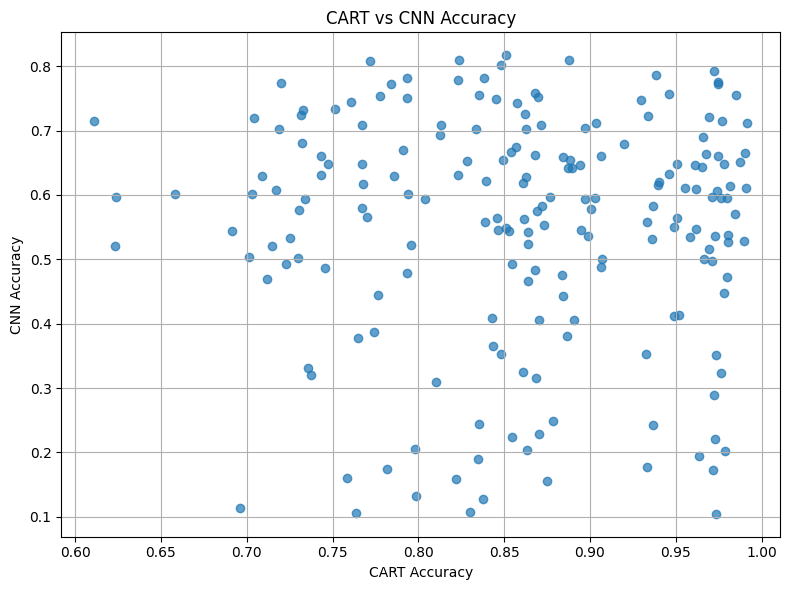

In [10]:
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_sorted["cart_accuracy"], df["cnn_accuracy"], alpha=0.7)

# Labeling
plt.xlabel("CART Accuracy")
plt.ylabel("CNN Accuracy")
plt.title("CART vs CNN Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()